In [45]:
import os
import xarray as xr
import pymc as pymc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import arviz as az
from scipy.special import expit

<h1>Helper functions</h1>

<h3>1. Convert SFI data to pandas format</h3>

In [46]:
import pandas as pd
import numpy as np

def sfi_file_to_pandas(filename):
    with open(filename, 'r') as f:
        inlines = f.readlines()

    outstruct = {}
    sitelist = []

    for line in inlines:
        if "year_start" in line:
            outstruct['year_start'] = int(line.split("=")[1].strip())
        elif "year_end" in line:
            outstruct['year_end'] = int(line.split("=")[1].strip())
        elif "[" in line:
            sitename = line.split("[")[1].split("]")[0]
            sitelist.append(sitename)

    nlines = len(inlines)
    ln = 0

    while ln < nlines:
        for sitename in sitelist:
            if sitename in inlines[ln]:
                nrules = int(inlines[ln + 1].split("=")[1])
                rules = {}
                for rule in range(nrules):
                    key, values = inlines[ln + 2 + rule].split("=")
                    rules[key.strip()] = [float(val) for val in values.strip().split(",")]
                outstruct[sitename] = rules
                ln += nrules + 2
                break
        else:
            ln += 1

    timeindex = pd.date_range(
        start=f"{outstruct['year_start']}-07-01",
        end=f"{outstruct['year_end']}-06-30",
        freq="YE-JUN"
    )

    dfs = [pd.DataFrame(outstruct[site], index=timeindex) for site in sitelist]
    outdf = pd.concat(dfs, axis=1, join='inner')

    return outdf


<h3>2. Calculate annual inflow from daily</h3>

In [47]:
def calculate_annual_inflow(inflow_file):
    """
    Reads inflow data from a CSV file, processes it, and calculates annual 
    inflow totals based on a June-ending year.
    
    Parameters:
        inflow_file (str): Path to the CSV file containing inflow data. 
                           The file must have a 'date' column.

    Returns:
        pd.DataFrame: Annual inflow totals with a June-ending year.
    """
    # Read inflow data and parse dates
    inflow_data = pd.read_csv(inflow_file, parse_dates=['date'])
    
    # Set the 'date' column as the index
    inflow_data.set_index('date', inplace=True)
    
    # Resample data to calculate annual totals for a June-ending year
    annual_inflow = inflow_data.resample("YE-JUN").sum()
    
    return annual_inflow

<h3>3. Get scenarios</h3>

In [48]:
all_indicators = {}

all_indicators["BMF"] = ["BMF_R1", "BMF_R2", "BMF_R3", "BMF_R4", "BMF_R5", "BMF_R6", "BMF_R7"]
all_indicators["CHO"] = ["CHO_R1", "CHO_R2", "CHO_R3", "CHO_R4", "CHO_R5", "CHO_R6", "CHO_R7"]

def get_indicators(location):
    return all_indicators[location]
    

<h3>4. Global variables</h3>

In [49]:
ewater_values = [0,2750]

<h1>Load data</h1>

In [50]:
# Set the directory where various input files are located
data_dir = "/datasets/lw-hydrofct/work/common/Staff/sch537/specific_flow_indicators/data/"

<h3>1. Achievement data</h3>
Load in success for all locations</br>
*B0H000* is the baseline diversion limit scenario and *P0H000* is the fully implemented plan scenario </br>
We therefore set ewater to 0.0 or 2750.0 accordingly.<br>

In [51]:
input_file_b = os.path.join(data_dir, "_MURR_B0H000__eFA_annual_stats_10discount.txt")
predictands_b = (sfi_file_to_pandas(input_file_b)).assign(ewater=0.0)
predictands_b["year_idx"] = np.arange(len(predictands_b))

input_file_p = os.path.join(data_dir, "_MURR_P0H000__eFA_annual_stats_10discount.txt")
predictands_p = (sfi_file_to_pandas(input_file_p)).assign(ewater=2750.0)
predictands_p["year_idx"] = np.arange(len(predictands_p))

predictands = pd.concat([predictands_b, predictands_p])
predictands.columns

Index(['BMF_R1', 'BMF_R2', 'BMF_R3', 'BMF_R4', 'BMF_R5', 'BMF_R6', 'BMF_R7',
       'GKP_R1', 'GKP_R2', 'GKP_R3', 'GKP_R4', 'GKP_R5', 'HAT_R1', 'HAT_R2',
       'HAT_R3', 'HAT_R4', 'HAT_R5', 'HAT_R6', 'CHO_R1', 'CHO_R2', 'CHO_R3',
       'CHO_R4', 'CHO_R5', 'CHO_R6', 'CHO_R7', 'EDW_R1', 'EDW_R2', 'EDW_R3',
       'EDW_R4', 'EDW_R5', 'LDF_R1', 'LDF_R2', 'LDF_R3', 'LDF_R4', 'LDF_R5',
       'ewater', 'year_idx'],
      dtype='object')

<h3>2. Inflow data</h3>
The "B" and "P" inflows are slightly different which we assume are caused by MDBA tweaks the model. We adopt
the "P" inflows for both ewater scenarios<br>
Despite the above, it is best practice to ensure that "B" and "P" files are read in the same order as the predictand data so the rows line up.

In [55]:
flow_var_to_use="local"

input_file_b = os.path.join(data_dir, "MURR_B0H.csv")
annual_predictor_b = calculate_annual_inflow(input_file_b)
annual_predictor_b["year_idx"] = np.arange(len(annual_predictor_b))

input_file_p = os.path.join(data_dir, "MURR_P0H.csv")
annual_predictor_p = calculate_annual_inflow(input_file_p)
annual_predictor_p["year_idx"] = np.arange(len(annual_predictor_p))

## NB: We are choosing one model to represent the inflows, hence using annual_predictor_p twice
annual_predictor_b["inflow"] = annual_predictor_p[flow_var_to_use]

# Data are concatenated so we have rows
annual_predictor = pd.concat([annual_predictor_b, annual_predictor_p])
annual_predictor["inflow"] = annual_predictor[flow_var_to_use]

# total inflow into the system
# outflow - flow out of the catchment 
# local - inflow from local catchment area

<h3>3. Calculate lagged inflow</h3>

In [56]:
annual_predictor["lagged_inflow"] = annual_predictor["inflow"].shift(1)

<h3>4. Join predictor and predictand data</h3>

In [57]:
data = predictands.copy()
for column in annual_predictor.columns:
    data[column] = annual_predictor[column]

# remove the first year (1896) since it is NaN for lagged case
# Use drop since the same date occurs multiple times in the data table
data = data.drop(datetime(1896,6,30))
# need to adjust year index accordingly to have 0-index
data["year_idx"] = data["year_idx"]-1

<h3>5. Calculate some inflow statistics</h3>

In [58]:
m = (data["local"]/1000.).mean()
s = (data["local"]/1000.).std()

print(f'mean: {m:.2f}')
print(f'std: {s:.2f}')

mean: 7208.81
std: 3129.95


In [59]:
data

BMF_R1  BMF_R2  BMF_R3  BMF_R4  BMF_R5  BMF_R6  BMF_R7  GKP_R1  \
1897-06-30     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1898-06-30     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1899-06-30     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1900-06-30     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1901-06-30     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2005-06-30     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2006-06-30     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2007-06-30     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2008-06-30     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2009-06-30     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

            GKP_R2  GKP_R3  ...  LDF_R2  LDF_R3  LDF_R4  LDF_R5  ewater  \
1897-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
1898-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
1899-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
1900-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
1901-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2005-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0  2750.0   
2006-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0  2750.0   
2007-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0  2750.0   
2008-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0  2750.0   
2009-06-30     0.0     0.0  ...     0.0     0.0     0.0     0.0  2750.0   

            year_idx        inflow    outflow         local  lagged_inflow  
1897-06-30         0  4.225391e+06   864139.0  4.225391e+06   5.594508e+06  
1898-06-30         1  4.986283e+06   578393.0  4.986283e+06   4.225391e+06  
1899-06-30         2  6.189946e+06  1135672.0  6.189946e+06   4.986283e+06  
1900-06-30         3  5.112734e+06  1742445.0  5.112734e+06   6.189946e+06  
1901-06-30         4  5.576845e+06  3637639.0  5.576845e+06   5.112734e+06  
...              ...           ...        ...           ...            ...  
2005-06-30       108  5.462452e+06  1711289.0  5.462452e+06   6.283502e+06  
2006-06-30       109  6.492137e+06  2754732.0  6.492137e+06   5.462452e+06  
2007-06-30       110  2.152755e+06   723644.0  2.152755e+06   6.492137e+06  
2008-06-30       111  2.827960e+06   396686.0  2.827960e+06   2.152755e+06  
2009-06-30       112  2.667191e+06   463345.0  2.667191e+06   2.827960e+06  

[226 rows x 41 columns]

<h1>Plot predictor/predictand data</h1>

<h3>1. Plot inflow annual time series</h3>

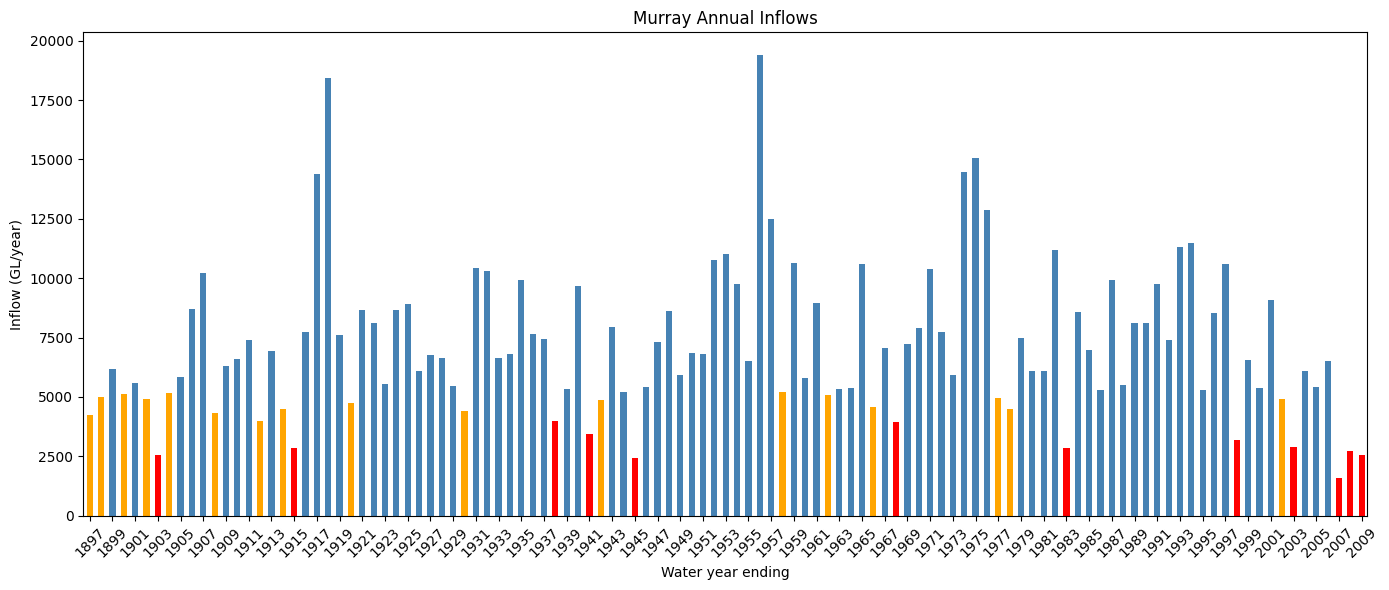

In [60]:


from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# hack to get a single time series
data_to_plot = data[:113]

# Calculate percentiles
p10 = data_to_plot['inflow'].quantile(0.10)
p25 = data_to_plot['inflow'].quantile(0.25)

# Create a color list based on the conditions
colors = []
for flow in data_to_plot['inflow']:
    if flow <= p10:
        colors.append('red')
    elif flow <= p25:
        colors.append('orange')
    else:
        colors.append('steelblue')

# Plot
plt.figure(figsize=(14, 6))
plt.bar(data_to_plot.index, data_to_plot['inflow']/1000., width=200, color=colors)

plt.xlabel('Water year ending')
plt.ylabel('Inflow (GL/year)')
plt.title('Murray Annual Inflows')
stride = 2
plt.xticks(data_to_plot.index[::stride], data_to_plot.index.strftime('%Y')[::stride], rotation=45)
plt.xlim(datetime(1896,12,1), datetime(2010,1,1))
plt.tight_layout()
plt.show()

<h3>2. Plot achievement time series</h3>

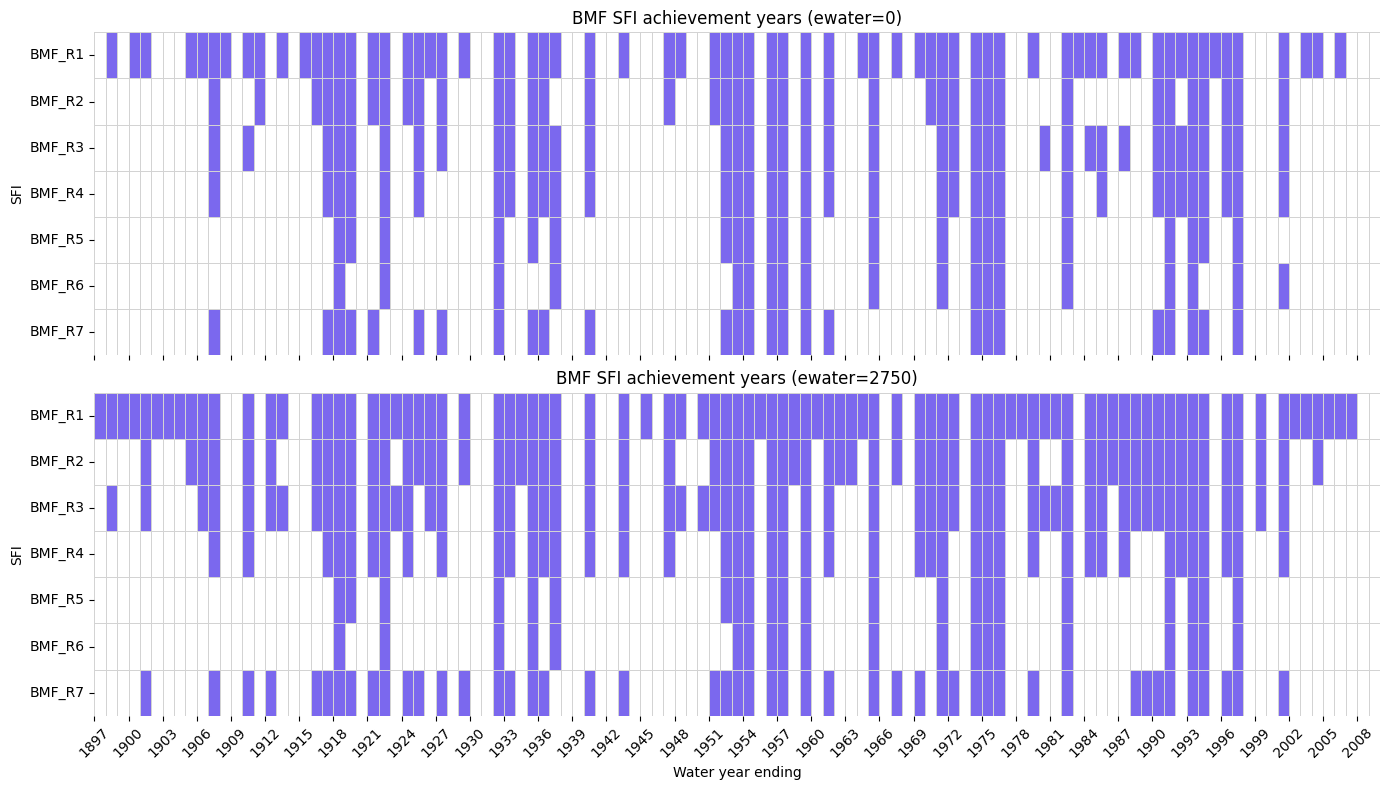

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

location = "BMF"
indicators = get_indicators(location)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

for ax, ewater in zip(axes, [0, 2750]):
    selected_data = data[data["ewater"] == ewater]
    selected_data = selected_data[indicators]
    
    sns.heatmap(
        selected_data.T,
        cmap=["white", "mediumslateblue"],
        cbar=False,
        linewidths=0.5,
        linecolor='lightgrey',
        ax=ax
    )

    ax.set_ylabel('SFI')
    ax.set_title(f'{location} SFI achievement years (ewater={ewater})')

# Shared x-axis label
axes[-1].set_xlabel('Water year ending')

# Format x-axis ticks only on the bottom plot
stride = 3
axes[-1].set_xticks(range(0, len(selected_data.index), stride))
axes[-1].set_xticklabels(
    selected_data.index.strftime('%Y')[::stride],
    rotation=45
)

# Remove x-ticks on top subplot
# axes[0].set_xticks([])

plt.tight_layout()
plt.show()


<h3>3. Count successes</h3>

In [21]:
# Extract data for both ewater scenarios
data_ewater_0 = data[data["ewater"] == 0][indicators]
data_ewater_2750 = data[data["ewater"] == 2750][indicators]

# Identify cases where success (1) occurs in ewater=0 but failure (0) in ewater=2750
failures_with_ewater = (data_ewater_0 == 1) & (data_ewater_2750 == 0)

# Convert to long format for easier interpretation
failures_df = failures_with_ewater.stack().reset_index()
failures_df.columns = ["Year", "Indicator", "Failed_with_ewater"]
failures_df = failures_df[failures_df["Failed_with_ewater"] == True].drop(columns=["Failed_with_ewater"])

# Display the table
print(failures_df)


          Year Indicator
77  1908-06-30    BMF_R1
98  1911-06-30    BMF_R1
99  1911-06-30    BMF_R2
126 1915-06-30    BMF_R1
198 1925-06-30    BMF_R3
199 1925-06-30    BMF_R4
528 1972-06-30    BMF_R4
602 1983-06-30    BMF_R1
654 1990-06-30    BMF_R4
686 1995-06-30    BMF_R1
733 2001-06-30    BMF_R6


In [22]:
import pandas as pd

indicators = get_indicators(location)

# Initialize dictionaries to store total successes and probabilities for each ewater scenario
success_counts = {}
success_probs = {}

# Loop through each ewater scenario and count successes and probabilities for each indicator
for ewater in ewater_values:
    selected_data = data[data["ewater"] == ewater]
    selected_data = selected_data[indicators]
    
    # Count total successes
    success_counts[ewater] = selected_data.sum()
    
    # Calculate probability of success (total successes / total years)
    success_probs[ewater] = selected_data.mean() * 100  # Multiply by 100 to express as a percentage

# Create a DataFrame with total successes and probabilities for each ewater scenario
summary_df = pd.DataFrame({
    'Successes (ewater=0)': success_counts[0],
    'Successes (ewater=2750)': success_counts[2750],
    '% Increase': 100 * (success_counts[2750] - success_counts[0]) / success_counts[0],
    'Prob. Success (ewater=0) %': success_probs[0],
    'Prob. Success (ewater=2750) %': success_probs[2750]
})

# Display the summary table
print(summary_df)


        Successes (ewater=0)  Successes (ewater=2750)  % Increase  \
BMF_R1                  68.0                     88.0   29.411765   
BMF_R2                  40.0                     64.0   60.000000   
BMF_R3                  40.0                     61.0   52.500000   
BMF_R4                  35.0                     43.0   22.857143   
BMF_R5                  22.0                     22.0    0.000000   
BMF_R6                  19.0                     20.0    5.263158   
BMF_R7                  26.0                     47.0   80.769231   

        Prob. Success (ewater=0) %  Prob. Success (ewater=2750) %  
BMF_R1                   60.176991                      77.876106  
BMF_R2                   35.398230                      56.637168  
BMF_R3                   35.398230                      53.982301  
BMF_R4                   30.973451                      38.053097  
BMF_R5                   19.469027                      19.469027  
BMF_R6                   16.814159     

<h1>Fit, check and cross-validate models</h1>

<h3>Set location</h3>

In [77]:
location = "CHO"

<h2>1. Combined model with all independent effects</h2>

<h3>1.1 Define model</h3>

In [78]:
def independent_effects_model(predictor1, predictor2, predictor3, predictand):
    
    with pymc.Model() as model:

        n = len(np.unique(predictor3))
        
        beta0 = pymc.Normal("beta0", mu=0, sigma=5, shape=n)
        beta1 = pymc.Normal("beta1", mu=0, sigma=5, shape=n)
        beta2 = pymc.Normal("beta2", mu=0, sigma=5, shape=n)
        
        x1 = pymc.Data("x1", predictor1)
        x2 = pymc.Data("x2", predictor2)
        idx = pymc.Data("idx", predictor3)

        mu = beta0[idx] + beta1[idx] * x1 + beta2[idx] * x2

        p = pymc.Deterministic("p", pmath.invlogit(mu))

        y = pymc.Bernoulli("y", p=p, observed=predictand)
    
    return model

<h3>1.2 Fit model</h3>

In [79]:
import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az

indicators = get_indicators(location)

sel_data = pd.melt(
    data,
    id_vars=['inflow', 'ewater', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

traces_combined_independent_effects = {}
data_combined_independent_effects = {}
    
predictor1 = np.log(sel_data["inflow"])
predictor1 = (predictor1 - predictor1.mean())/predictor1.std()

predictor2 = sel_data["ewater"]
predictor2 = (predictor2 / sel_data["ewater"].max()) - 0.5

predictor3 = sel_data["indicator_idx"]

predictand = sel_data["target"]
        
model = independent_effects_model(predictor1, predictor2, predictor3, predictand)
    
# Perform MCMC sampling
trace = pymc.sample(
    draws=2000,
    tune=4000,
    chains=4,
    target_accept=0.85,
    model=model
)
   
traces_combined_independent_effects[f"{location}"] = trace
    
ptor_ptand_data = pd.DataFrame(predictor1)
ptor_ptand_data = ptor_ptand_data.rename({"inflow":"predictor1"}, axis=1)
ptor_ptand_data["ewater"] = predictor2
ptor_ptand_data["indicator_idx"] = predictor3
ptor_ptand_data["predictand"] = predictand
        
data_combined_independent_effects[f"{location}"] = ptor_ptand_data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 51 seconds.


<h3>1.3 Plot traces</h3>

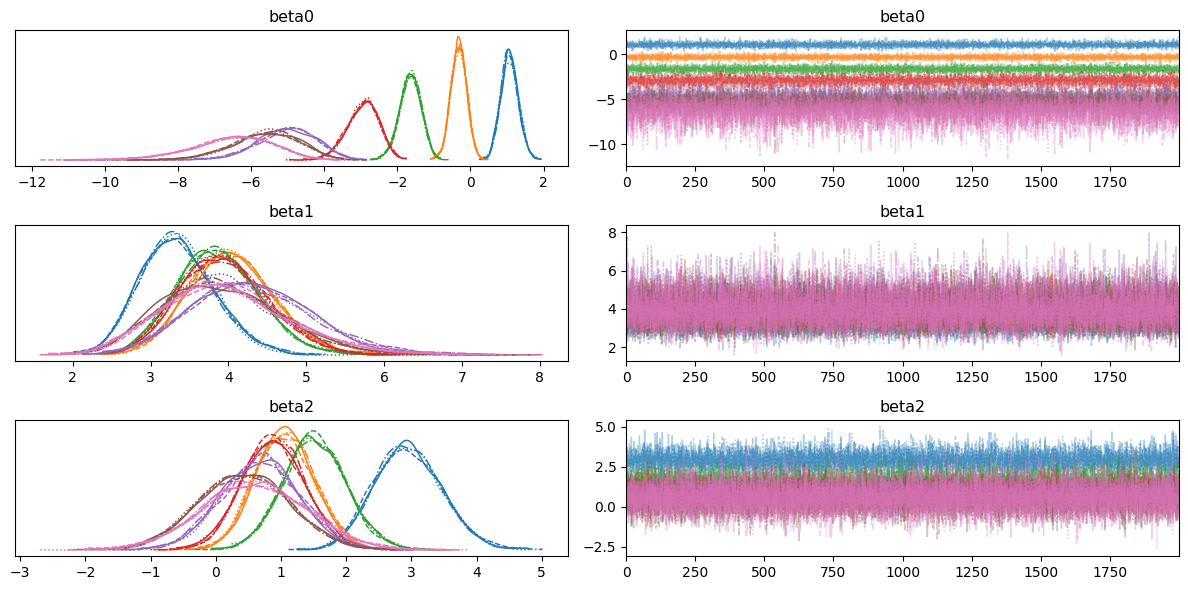

In [80]:
import matplotlib.pyplot as plt
import arviz as az

az.summary(trace, var_names=["beta0", "beta1", "beta2"], filter_vars="like", kind="diagnostics")
az.plot_trace(trace, var_names=["beta0", "beta1", "beta2"])
plt.tight_layout()
plt.show()

<h3>1.4 Plot posterior success probability against flow and observations</h3>

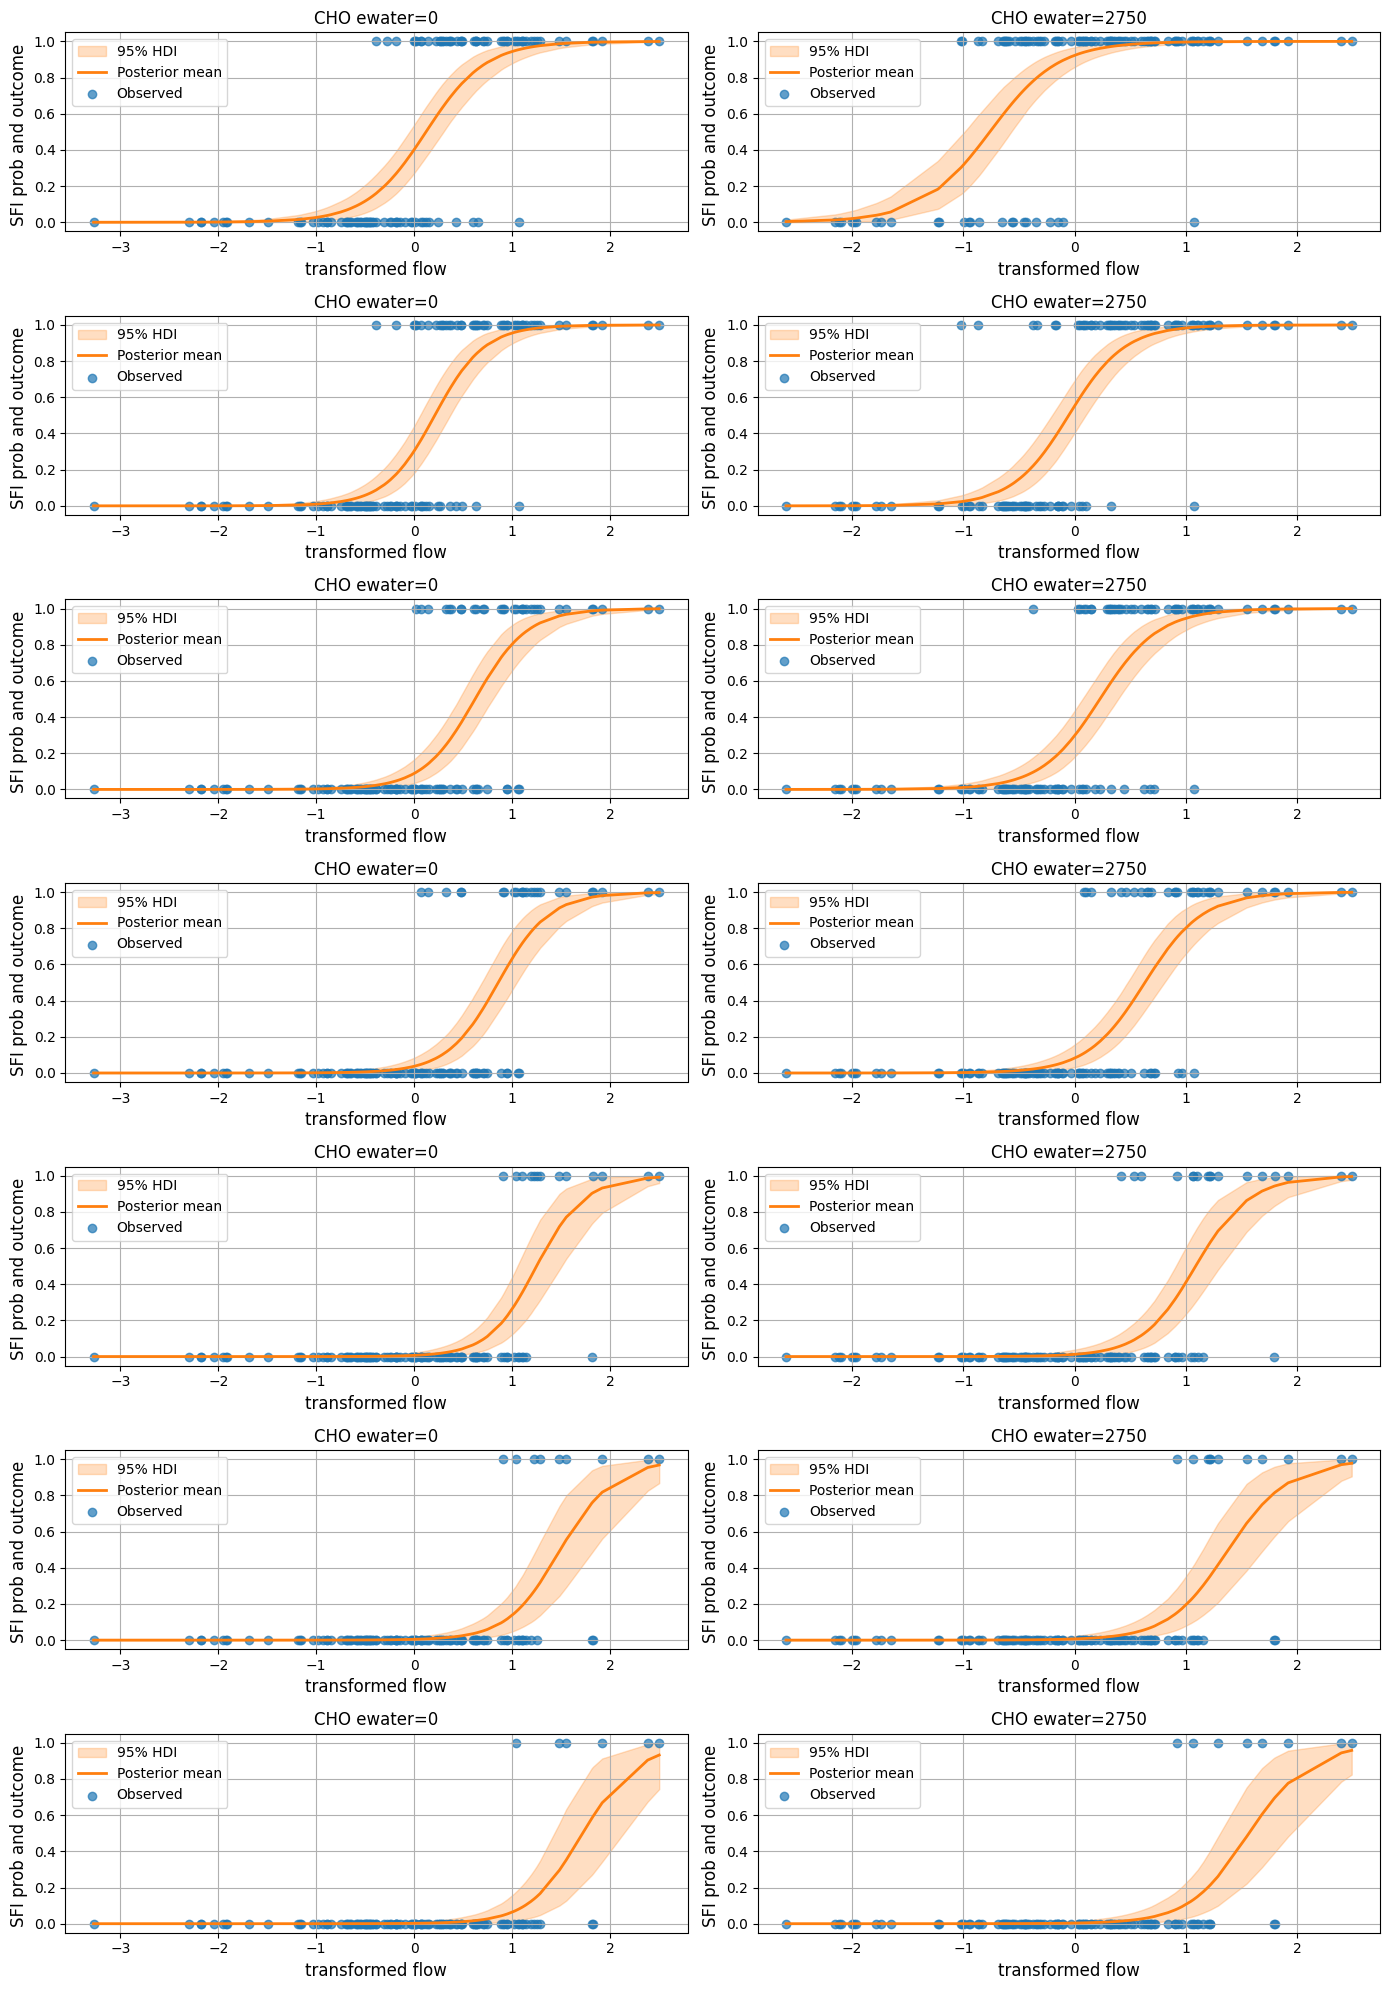

In [81]:
def plot_posterior_vs_predictor(location,indicator_idx,ewater_idx, trace, data, ax=None):

    def hdi(samples, hdi_prob=0.95):
        """
        Compute the High Density Interval (HDI) using percentiles.
        """
        lower_percentile = (1 - hdi_prob) / 2
        upper_percentile = 1 - lower_percentile
        lower_bound = np.percentile(samples, lower_percentile * 100, axis=0)
        upper_bound = np.percentile(samples, upper_percentile * 100, axis=0)
        return np.array([lower_bound, upper_bound]).T   

    ewater_predictor = ewater_values[ewater_idx] / np.max(ewater_values) - 0.5
    
    sel_data = data[data["indicator_idx"]==indicator_idx]
    sel_data = sel_data[sel_data["ewater"]==ewater_predictor]

    # Sort the data by the predictor values
    sorted_data = sel_data.sort_values(by="predictor1")   
    sorted_x1 = sorted_data["predictor1"].values

    # Extract posterior samples
    beta0_samples = trace.posterior["beta0"][:,:,indicator_idx].values.ravel()
    beta1_samples = trace.posterior["beta1"][:,:,indicator_idx].values.ravel()
    beta2_samples = trace.posterior["beta2"][:,:,indicator_idx].values.ravel()
    
    mu_samples = beta0_samples[:, None] + beta1_samples[:, None] * sorted_x1  + \
                 beta2_samples[:, None] * ewater_predictor

    # Calculate probabilities using the inverse logit
    p_samples = 1 / (1 + np.exp(-mu_samples))

    # Compute mean and 95% HDI of the posterior predictions
    mean_posterior = np.mean(p_samples, axis=0)
    hdi_posterior = hdi(p_samples, hdi_prob=0.95)

    # Plot the 95% HDI for the posterior probabilities
    ax.fill_between(sorted_x1, hdi_posterior[:, 0], hdi_posterior[:, 1], color="C1", alpha=0.25, label="95% HDI")

    # Plot the mean posterior probabilities
    ax.plot(sorted_x1, mean_posterior, color="C1", label="Posterior mean", linewidth=2)

    observed = sorted_data["predictand"].values
    ax.scatter(sorted_x1, observed, label="Observed", color="C0", alpha=0.7)

    # Set plot labels
    ax.set_xlabel(f"transformed flow", fontsize=12)
    ax.set_ylabel(f"SFI prob and outcome ", fontsize=12)
    
    title_text = f"{location} ewater={ewater_values[ewater_idx]}"
    ax.set_title(title_text, fontsize=12)

    # Add a legend
    ax.legend(loc="best")

    # Add gridlines for readability
    ax.grid(True)


# Create a figure with subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(14, 20))

# Flatten the axes array to iterate over it
axes = axes.flatten()

indicators = get_indicators(location)

for i, indicator in enumerate(indicators):    
    for j, ewater in enumerate(ewater_values):
                
        model_trace = traces_combined_independent_effects[location]
        model_data = data_combined_independent_effects[location]
        ax = axes[i * 2 + j]  # Select the appropriate axis for the plot
        plot_posterior_vs_predictor(location,i,j,trace=model_trace, data=model_data, ax=ax)
        
plt.tight_layout()
plt.show()

<h3>1.5 Cross-validation</h3>

In [82]:
import time

import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az
import xarray as xr

indicators = get_indicators(location)

nyears = data['year_idx'].nunique()
nsplits = 20
nchains = 4
ndraws = 4000
ntune = 2000
nsamples = nchains * ndraws

bin_width = nyears / nsplits
bin_edges = [int(i * bin_width) for i in range(nsplits + 1)]

predictive_samples_array = np.full((len(ewater_values), len(indicators), nyears, nsamples), np.nan)
obs_array = np.full((len(ewater_values), len(indicators), nyears), np.nan)

n_xv_iterations = len(ewater_values) * nsplits
xv_i = 1
time0 = time.time()

# sel_data = data[indicators + ["inflow", "ewater", "year_idx"]]
# Melt the dataframe
sel_data = pd.melt(
    data,
    id_vars=['inflow', 'ewater', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

for split_i in range(nsplits):

    test_years_idx = np.arange(bin_edges[split_i], bin_edges[split_i + 1], dtype=int)

    test_data = sel_data[sel_data["year_idx"].isin(test_years_idx)]
    train_data = sel_data[~sel_data["year_idx"].isin(test_years_idx)]

    # Standardize inflow on training set
    predictor1_training = np.log(train_data["inflow"])
    predictor1_training_mean = predictor1_training.mean()
    predictor1_training_std = predictor1_training.std()
    predictor1_training = (predictor1_training - predictor1_training_mean) / predictor1_training_std

    predictor1_test = np.log(test_data["inflow"])
    predictor1_test = (predictor1_test - predictor1_training_mean) / predictor1_training_std

    predictor2_training = train_data["ewater"]
    predictor2_training = (predictor2_training / data["ewater"].max()) - 0.5
    predictor2_test = test_data["ewater"]
    predictor2_test = (predictor2_test / data["ewater"].max()) - 0.5

    predictor3_training = train_data["indicator_idx"]
    predictor3_test = test_data["indicator_idx"]

    predictand_training = train_data["target"]
    predictand_test = test_data["target"]

    # ====== PyMC Model =======

    model = independent_effects_model(predictor1_training, predictor2_training, predictor3_training, predictand_training)

    trace = pymc.sample(draws=ndraws, tune=ntune, chains=nchains, target_accept=0.85,
                       model=model)

    for ewater_i, ewater in enumerate(ewater_values):
        ewater_scaled = ewater / data["ewater"].max() - 0.5
        ewater_idx = predictor2_test == ewater_scaled

        with model:
            pymc.set_data({
                "x1": predictor1_test[ewater_idx],
                "x2": predictor2_test[ewater_idx],
                "idx": predictor3_test[ewater_idx]
            })

            posterior_pred = pymc.sample_posterior_predictive(trace, var_names=["p"], progressbar=False, predictions=True)
            posterior_predictive_samples = posterior_pred.predictions["p"].values
            posterior_predictive_samples = posterior_predictive_samples.reshape(-1, posterior_predictive_samples.shape[2]).T

            # Fill arrays
            for ind_i in range(len(indicators)):
                ind_mask = predictor3_test[ewater_idx] == ind_i
                year_idx_subset = test_data["year_idx"][ewater_idx][ind_mask]
                predictive_samples_array[ewater_i, ind_i, year_idx_subset, :] = posterior_predictive_samples[ind_mask]
                obs_array[ewater_i, ind_i, year_idx_subset] = predictand_test[ewater_idx][ind_mask]

        print(f"{xv_i / n_xv_iterations * 100:.2f}% of cross-validation loops complete.   {time.time() - time0:.2f}s elapsed")
        xv_i += 1


# Create xarrays and save as before
predictions_dict = {
    "ewater": np.array([0, 1]),
    "indicator_idx": np.arange(len(indicators), dtype=int),
    "year_idx": data['year_idx'].unique(),
    "sample": np.arange(nsamples)
}

obs_dict = {
    "ewater": np.array([0, 1]),
    "indicator_idx": np.arange(len(indicators), dtype=int),
    "year_idx": data['year_idx'].unique()
}

predictions_xr = xr.DataArray(predictive_samples_array, coords=predictions_dict, dims=["ewater", "indicator_idx", "year_idx", "sample"])
obs_xr = xr.DataArray(obs_array, coords=obs_dict, dims=["ewater", "indicator_idx", "year_idx"])

predictions_xr.to_netcdf(f'../../../data/xv_data/{location}_posterior_predictive_combined_ind_intercept_inflow_ewater_model.nc')
obs_xr.to_netcdf(f'../../../data/xv_data/{location}_obs_combined_ind_intercept_inflow_ewater_model.nc')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 47 seconds.
Sampling: []
Sampling: []


2.50% of cross-validation loops complete.   51.03s elapsed
5.00% of cross-validation loops complete.   51.40s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 47 seconds.
Sampling: []
Sampling: []


7.50% of cross-validation loops complete.   102.31s elapsed
10.00% of cross-validation loops complete.   102.68s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 48 seconds.
Sampling: []
Sampling: []


12.50% of cross-validation loops complete.   155.86s elapsed
15.00% of cross-validation loops complete.   156.22s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 61 seconds.
Sampling: []
Sampling: []


17.50% of cross-validation loops complete.   221.68s elapsed
20.00% of cross-validation loops complete.   222.06s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 53 seconds.
Sampling: []
Sampling: []


22.50% of cross-validation loops complete.   280.39s elapsed
25.00% of cross-validation loops complete.   280.76s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 48 seconds.
Sampling: []
Sampling: []


27.50% of cross-validation loops complete.   333.04s elapsed
30.00% of cross-validation loops complete.   333.39s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 51 seconds.
Sampling: []
Sampling: []


32.50% of cross-validation loops complete.   388.60s elapsed
35.00% of cross-validation loops complete.   388.95s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 48 seconds.
Sampling: []
Sampling: []


37.50% of cross-validation loops complete.   442.20s elapsed
40.00% of cross-validation loops complete.   442.57s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 48 seconds.
Sampling: []
Sampling: []


42.50% of cross-validation loops complete.   495.12s elapsed
45.00% of cross-validation loops complete.   495.50s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 47 seconds.
Sampling: []
Sampling: []


47.50% of cross-validation loops complete.   546.47s elapsed
50.00% of cross-validation loops complete.   546.87s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 46 seconds.
Sampling: []
Sampling: []


52.50% of cross-validation loops complete.   598.44s elapsed
55.00% of cross-validation loops complete.   598.82s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 47 seconds.
Sampling: []
Sampling: []


57.50% of cross-validation loops complete.   650.10s elapsed
60.00% of cross-validation loops complete.   650.46s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 47 seconds.
Sampling: []
Sampling: []


62.50% of cross-validation loops complete.   702.80s elapsed
65.00% of cross-validation loops complete.   703.19s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 53 seconds.
Sampling: []
Sampling: []


67.50% of cross-validation loops complete.   760.58s elapsed
70.00% of cross-validation loops complete.   760.95s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 46 seconds.
Sampling: []
Sampling: []


72.50% of cross-validation loops complete.   811.27s elapsed
75.00% of cross-validation loops complete.   811.62s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 47 seconds.
Sampling: []
Sampling: []


77.50% of cross-validation loops complete.   864.25s elapsed
80.00% of cross-validation loops complete.   864.63s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 49 seconds.
Sampling: []
Sampling: []


82.50% of cross-validation loops complete.   917.42s elapsed
85.00% of cross-validation loops complete.   917.78s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 46 seconds.
Sampling: []
Sampling: []


87.50% of cross-validation loops complete.   969.69s elapsed
90.00% of cross-validation loops complete.   970.05s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 46 seconds.
Sampling: []
Sampling: []


92.50% of cross-validation loops complete.   1019.98s elapsed
95.00% of cross-validation loops complete.   1020.36s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 45 seconds.
Sampling: []
Sampling: []


97.50% of cross-validation loops complete.   1070.79s elapsed
100.00% of cross-validation loops complete.   1071.15s elapsed


<h2>2. Combined model with interaction term</h2>
The interaction means the effects of ewater depend on inflow.

<h3>2.1 Define model</h3>

In [213]:
def interaction_model(predictor1, predictor2, predictor3, predictand):
    
    with pymc.Model() as model:

        n = len(np.unique(predictor3))
        
        beta0 = pymc.Normal("beta0", mu=0, sigma=5, shape=n)
        beta1 = pymc.Normal("beta1", mu=0, sigma=5, shape=n)
        beta2 = pymc.Normal("beta2", mu=0, sigma=5, shape=n)
        beta3 = pymc.Normal("beta3", mu=0, sigma=5, shape=n)
        
        x1 = pymc.Data("x1", predictor1)
        x2 = pymc.Data("x2", predictor2)
        idx = pymc.Data("idx", predictor3)

        mu = beta0[idx] + beta1[idx] * x1 + beta2[idx] * x2 + \
            beta3[idx] * x1 * x2  # Interaction
        
        p = pymc.Deterministic("p", pmath.invlogit(mu))

        y = pymc.Bernoulli("y", p=p, observed=predictand)
    
    return model

<h3>2.2 Fit model</h3>

In [214]:
import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az

indicators = get_indicators(location)

sel_data = pd.melt(
    data,
    id_vars=['inflow', 'ewater', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

traces_combined_interaction = {}
data_combined_interaction = {}
    
predictor1 = np.log(sel_data["inflow"])
predictor1 = (predictor1 - predictor1.mean())/predictor1.std()

predictor2 = sel_data["ewater"]
predictor2 = (predictor2 / sel_data["ewater"].max()) - 0.5

predictor3 = sel_data["indicator_idx"]

predictand = sel_data["target"]
        
model = interaction_model(predictor1, predictor2, predictor3, predictand)
    
# Perform MCMC sampling
trace = pymc.sample(
    draws=2000,
    tune=4000,
    chains=4,
    target_accept=0.85,
    model=model
)
   
traces_combined_interaction[f"{location}"] = trace
    
ptor_ptand_data = pd.DataFrame(predictor1)
ptor_ptand_data = ptor_ptand_data.rename({"inflow":"predictor1"}, axis=1)
ptor_ptand_data["ewater"] = predictor2
ptor_ptand_data["indicator_idx"] = predictor3
ptor_ptand_data["predictand"] = predictand
        
data_combined_interaction[f"{location}"] = ptor_ptand_data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 52 seconds.


<h3>2.3 Plot traces</h3>

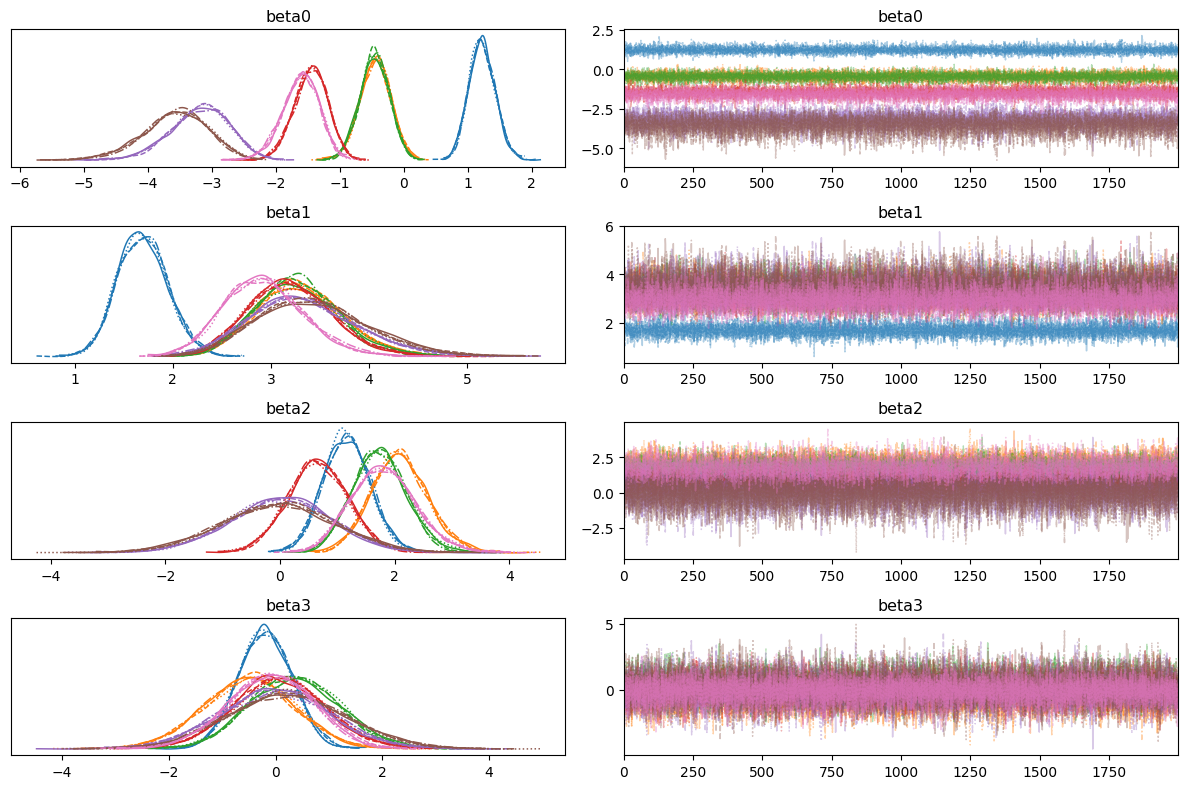

In [215]:
import matplotlib.pyplot as plt
import arviz as az

az.summary(trace, var_names=["beta0", "beta1", "beta2", "beta3"], filter_vars="like", kind="diagnostics")
az.plot_trace(trace, var_names=["beta0", "beta1", "beta2", "beta3"])
plt.tight_layout()
plt.show()

<h3>2.4 Plot posterior success probabilty against flow and observations</h3>


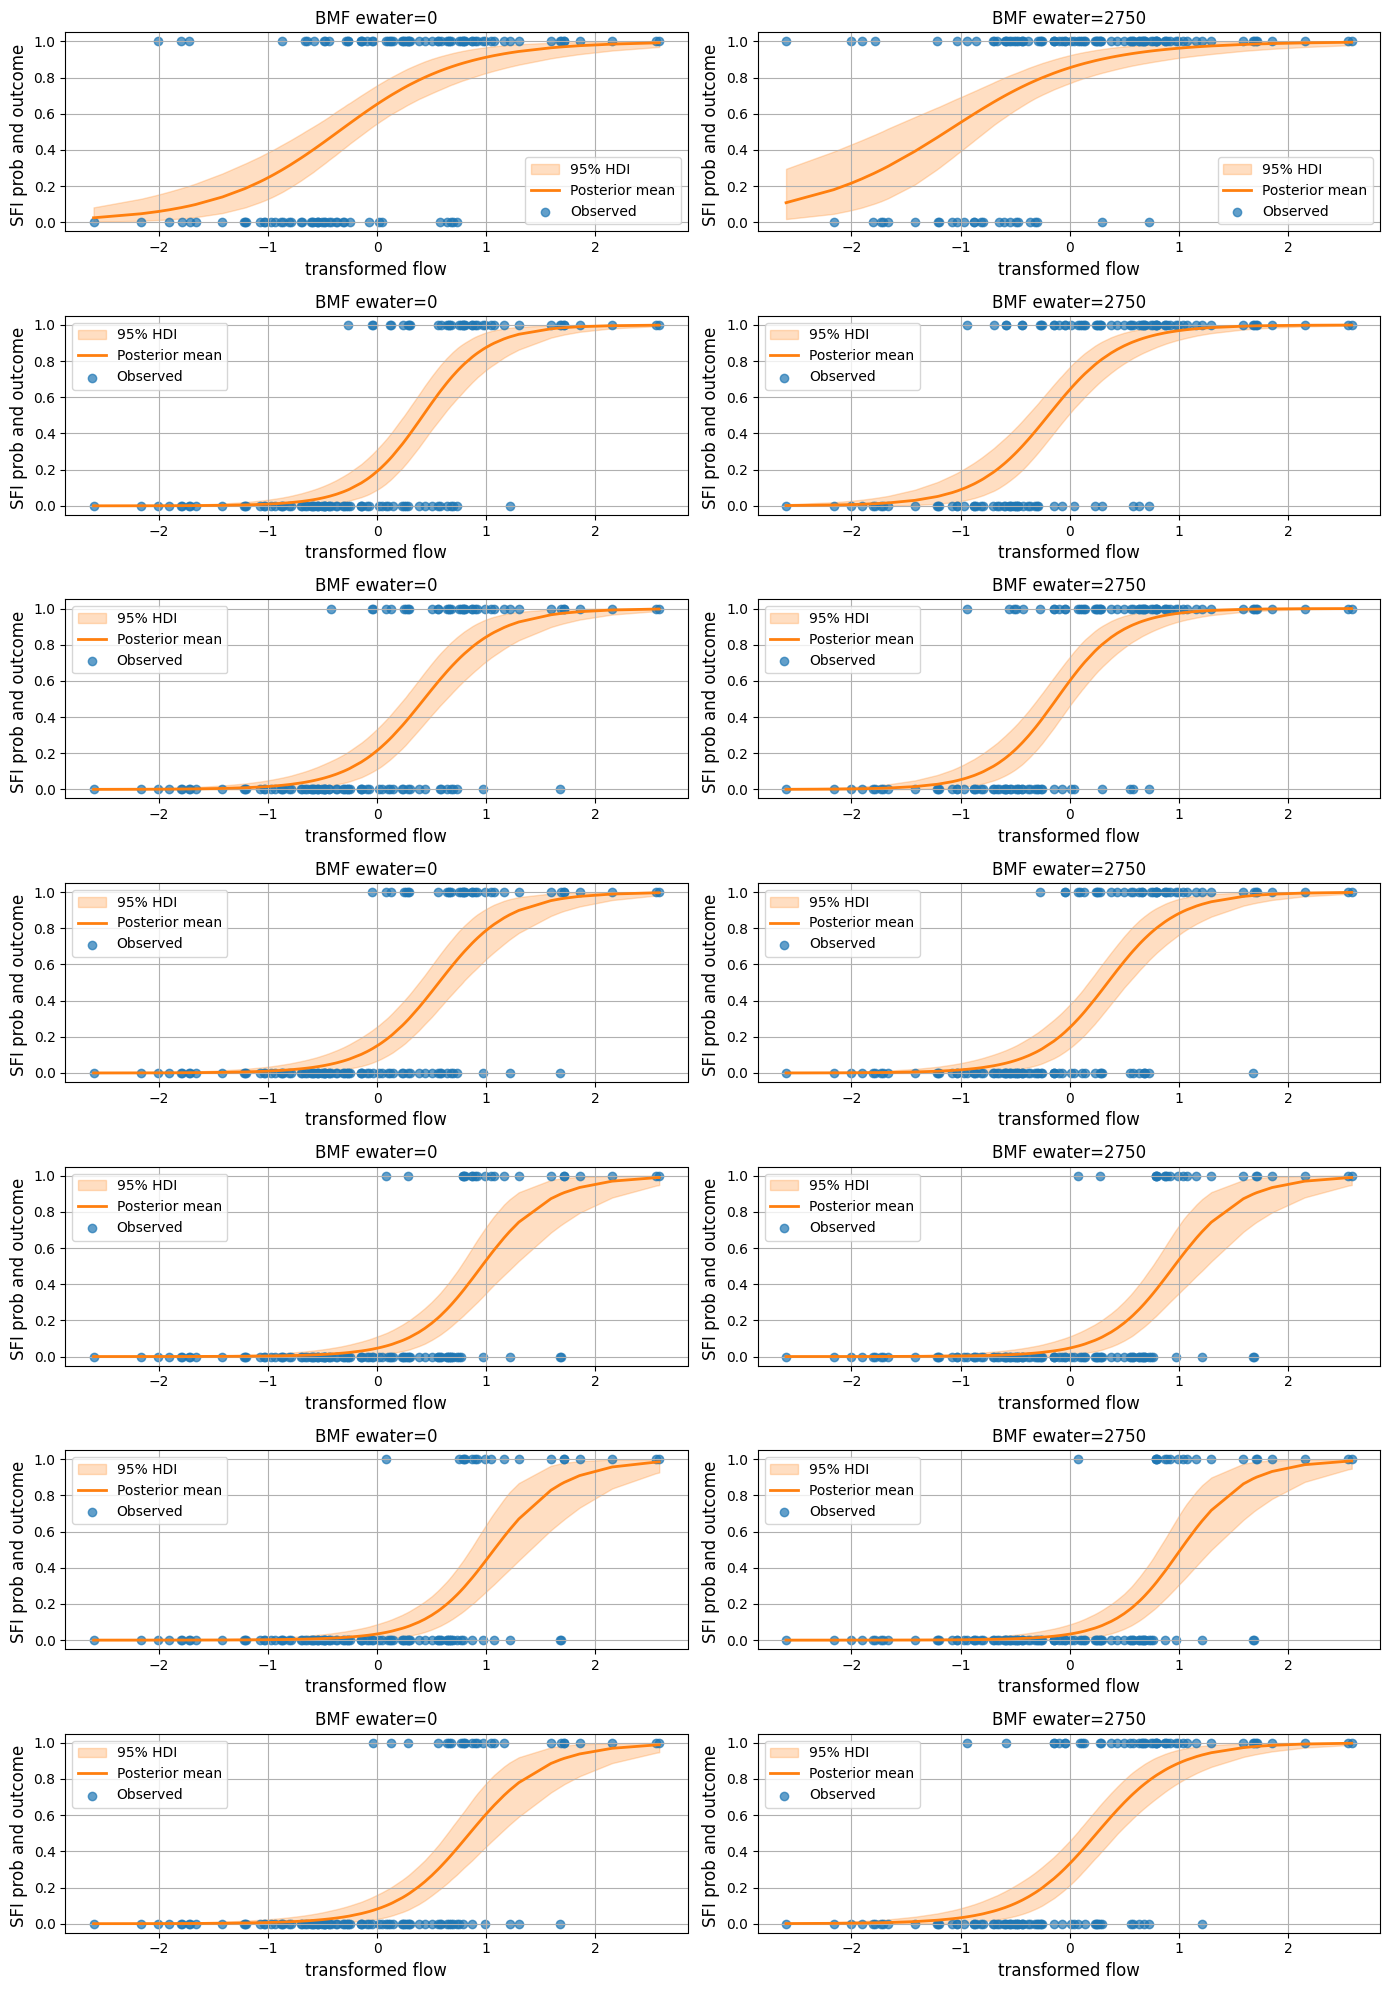

In [216]:
def plot_posterior_vs_predictor(location,indicator_idx,ewater_idx, trace, data, ax=None):

    def hdi(samples, hdi_prob=0.95):
        """
        Compute the High Density Interval (HDI) using percentiles.
        """
        lower_percentile = (1 - hdi_prob) / 2
        upper_percentile = 1 - lower_percentile
        lower_bound = np.percentile(samples, lower_percentile * 100, axis=0)
        upper_bound = np.percentile(samples, upper_percentile * 100, axis=0)
        return np.array([lower_bound, upper_bound]).T   

    ewater_predictor = ewater_values[ewater_idx] / np.max(ewater_values) - 0.5
    
    sel_data = data[data["indicator_idx"]==indicator_idx]
    sel_data = sel_data[sel_data["ewater"]==ewater_predictor]

    # Sort the data by the predictor values
    sorted_data = sel_data.sort_values(by="predictor1")   
    sorted_x1 = sorted_data["predictor1"].values

    # Extract posterior samples
    beta0_samples = trace.posterior["beta0"][:,:,indicator_idx].values.ravel()
    beta1_samples = trace.posterior["beta1"][:,:,indicator_idx].values.ravel()
    beta2_samples = trace.posterior["beta2"][:,:,indicator_idx].values.ravel()
    beta3_samples = trace.posterior["beta3"][:,:,indicator_idx].values.ravel()
    
    mu_samples = beta0_samples[:, None] + beta1_samples[:, None] * sorted_x1  + \
                 beta2_samples[:, None] * ewater_predictor +  beta3_samples[:, None] * sorted_x1 * ewater_predictor

    # Calculate probabilities using the inverse logit
    p_samples = 1 / (1 + np.exp(-mu_samples))

    # Compute mean and 95% HDI of the posterior predictions
    mean_posterior = np.mean(p_samples, axis=0)
    hdi_posterior = hdi(p_samples, hdi_prob=0.95)

    # Plot the 95% HDI for the posterior probabilities
    ax.fill_between(sorted_x1, hdi_posterior[:, 0], hdi_posterior[:, 1], color="C1", alpha=0.25, label="95% HDI")

    # Plot the mean posterior probabilities
    ax.plot(sorted_x1, mean_posterior, color="C1", label="Posterior mean", linewidth=2)

    observed = sorted_data["predictand"].values
    ax.scatter(sorted_x1, observed, label="Observed", color="C0", alpha=0.7)

    # Set plot labels
    ax.set_xlabel(f"transformed flow", fontsize=12)
    ax.set_ylabel(f"SFI prob and outcome ", fontsize=12)
    
    title_text = f"{location} ewater={ewater_values[ewater_idx]}"
    ax.set_title(title_text, fontsize=12)

    # Add a legend
    ax.legend(loc="best")

    # Add gridlines for readability
    ax.grid(True)


# Create a figure with subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(14, 20))

# Flatten the axes array to iterate over it
axes = axes.flatten()

indicators = get_indicators(location)

for i, indicator in enumerate(indicators):    
    for j, ewater in enumerate(ewater_values):
                
        model_trace = traces_combined_interaction[location]
        model_data = data_combined_interaction[location]
        ax = axes[i * 2 + j]  # Select the appropriate axis for the plot
        plot_posterior_vs_predictor(location,i,j,trace=model_trace, data=model_data, ax=ax)
        
plt.tight_layout()
plt.show()

<h3>2.5 Cross validation</h3>

In [217]:
import time

import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az
import xarray as xr

indicators = get_indicators(location)

nyears = data['year_idx'].nunique()
nsplits = 20
nchains = 4
ndraws = 4000
ntune = 2000
nsamples = nchains * ndraws

bin_width = nyears / nsplits
bin_edges = [int(i * bin_width) for i in range(nsplits + 1)]

predictive_samples_array = np.full((len(ewater_values), len(indicators), nyears, nsamples), np.nan)
obs_array = np.full((len(ewater_values), len(indicators), nyears), np.nan)

n_xv_iterations = len(ewater_values) * nsplits
xv_i = 1
time0 = time.time()

# sel_data = data[indicators + ["inflow", "ewater", "year_idx"]]
# Melt the dataframe
sel_data = pd.melt(
    data,
    id_vars=['inflow', 'ewater', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

for split_i in range(nsplits):

    test_years_idx = np.arange(bin_edges[split_i], bin_edges[split_i + 1], dtype=int)

    test_data = sel_data[sel_data["year_idx"].isin(test_years_idx)]
    train_data = sel_data[~sel_data["year_idx"].isin(test_years_idx)]

    # Standardize inflow on training set
    predictor1_training = np.log(train_data["inflow"])
    predictor1_training_mean = predictor1_training.mean()
    predictor1_training_std = predictor1_training.std()
    predictor1_training = (predictor1_training - predictor1_training_mean) / predictor1_training_std

    predictor1_test = np.log(test_data["inflow"])
    predictor1_test = (predictor1_test - predictor1_training_mean) / predictor1_training_std

    predictor2_training = train_data["ewater"]
    predictor2_training = (predictor2_training / data["ewater"].max()) - 0.5
    predictor2_test = test_data["ewater"]
    predictor2_test = (predictor2_test / data["ewater"].max()) - 0.5

    predictor3_training = train_data["indicator_idx"]
    predictor3_test = test_data["indicator_idx"]

    predictand_training = train_data["target"]
    predictand_test = test_data["target"]

    model = interaction_model(predictor1_training, predictor2_training, predictor3_training, predictand_training)

    trace = pymc.sample(draws=ndraws, tune=ntune, chains=nchains, target_accept=0.85,
                       model=model)

    for ewater_i, ewater in enumerate(ewater_values):
        ewater_scaled = ewater / data["ewater"].max() - 0.5
        ewater_idx = predictor2_test == ewater_scaled

        with model:
            pymc.set_data({
                "x1": predictor1_test[ewater_idx],
                "x2": predictor2_test[ewater_idx],
                "idx": predictor3_test[ewater_idx]
            })

            posterior_pred = pymc.sample_posterior_predictive(trace, var_names=["p"], progressbar=False, predictions=True)
            posterior_predictive_samples = posterior_pred.predictions["p"].values
            posterior_predictive_samples = posterior_predictive_samples.reshape(-1, posterior_predictive_samples.shape[2]).T

            # Fill arrays
            for ind_i in range(len(indicators)):
                ind_mask = predictor3_test[ewater_idx] == ind_i
                year_idx_subset = test_data["year_idx"][ewater_idx][ind_mask]
                predictive_samples_array[ewater_i, ind_i, year_idx_subset, :] = posterior_predictive_samples[ind_mask]
                obs_array[ewater_i, ind_i, year_idx_subset] = predictand_test[ewater_idx][ind_mask]

        print(f"{xv_i / n_xv_iterations * 100:.2f}% of cross-validation loops complete.   {time.time() - time0:.2f}s elapsed")
        xv_i += 1


# Create xarrays and save as before
predictions_dict = {
    "ewater": np.array([0, 1]),
    "indicator_idx": np.arange(len(indicators), dtype=int),
    "year_idx": data['year_idx'].unique(),
    "sample": np.arange(nsamples)
}

obs_dict = {
    "ewater": np.array([0, 1]),
    "indicator_idx": np.arange(len(indicators), dtype=int),
    "year_idx": data['year_idx'].unique()
}

predictions_xr = xr.DataArray(predictive_samples_array, coords=predictions_dict, dims=["ewater", "indicator_idx", "year_idx", "sample"])
obs_xr = xr.DataArray(obs_array, coords=obs_dict, dims=["ewater", "indicator_idx", "year_idx"])

predictions_xr.to_netcdf(f'../../../data/xv_data/{location}_posterior_predictive_combined_interaction_model.nc')
obs_xr.to_netcdf(f'../../../data/xv_data/{location}_obs_combined_interaction_model.nc')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 52 seconds.
Sampling: []
Sampling: []


2.50% of cross-validation loops complete.   58.33s elapsed
5.00% of cross-validation loops complete.   58.78s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 53 seconds.
Sampling: []
Sampling: []


7.50% of cross-validation loops complete.   117.72s elapsed
10.00% of cross-validation loops complete.   118.17s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 52 seconds.
Sampling: []
Sampling: []


12.50% of cross-validation loops complete.   175.93s elapsed
15.00% of cross-validation loops complete.   176.38s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 58 seconds.
Sampling: []
Sampling: []


17.50% of cross-validation loops complete.   242.01s elapsed
20.00% of cross-validation loops complete.   242.45s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 53 seconds.
Sampling: []
Sampling: []


22.50% of cross-validation loops complete.   301.95s elapsed
25.00% of cross-validation loops complete.   302.39s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 55 seconds.
Sampling: []
Sampling: []


27.50% of cross-validation loops complete.   364.94s elapsed
30.00% of cross-validation loops complete.   365.40s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 52 seconds.
Sampling: []
Sampling: []


32.50% of cross-validation loops complete.   423.40s elapsed
35.00% of cross-validation loops complete.   423.85s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 56 seconds.
Sampling: []
Sampling: []


37.50% of cross-validation loops complete.   485.29s elapsed
40.00% of cross-validation loops complete.   485.72s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 54 seconds.
Sampling: []
Sampling: []


42.50% of cross-validation loops complete.   547.04s elapsed
45.00% of cross-validation loops complete.   547.50s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 56 seconds.
Sampling: []
Sampling: []


47.50% of cross-validation loops complete.   609.51s elapsed
50.00% of cross-validation loops complete.   609.94s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 56 seconds.
Sampling: []
Sampling: []


52.50% of cross-validation loops complete.   673.08s elapsed
55.00% of cross-validation loops complete.   673.53s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 53 seconds.
Sampling: []
Sampling: []


57.50% of cross-validation loops complete.   732.31s elapsed
60.00% of cross-validation loops complete.   732.76s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 52 seconds.
Sampling: []
Sampling: []


62.50% of cross-validation loops complete.   792.56s elapsed
65.00% of cross-validation loops complete.   793.02s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 55 seconds.
Sampling: []
Sampling: []


67.50% of cross-validation loops complete.   854.72s elapsed
70.00% of cross-validation loops complete.   855.16s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 53 seconds.
Sampling: []
Sampling: []


72.50% of cross-validation loops complete.   913.97s elapsed
75.00% of cross-validation loops complete.   914.45s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 55 seconds.
Sampling: []
Sampling: []


77.50% of cross-validation loops complete.   977.29s elapsed
80.00% of cross-validation loops complete.   977.74s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 53 seconds.
Sampling: []
Sampling: []


82.50% of cross-validation loops complete.   1036.79s elapsed
85.00% of cross-validation loops complete.   1037.22s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 55 seconds.
Sampling: []
Sampling: []


87.50% of cross-validation loops complete.   1101.19s elapsed
90.00% of cross-validation loops complete.   1101.65s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 49 seconds.
Sampling: []
Sampling: []


92.50% of cross-validation loops complete.   1156.97s elapsed
95.00% of cross-validation loops complete.   1157.39s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 51 seconds.
Sampling: []
Sampling: []


97.50% of cross-validation loops complete.   1216.32s elapsed
100.00% of cross-validation loops complete.   1216.79s elapsed


<h2>3. Combined model with shared slopes</h2>

<h3>3.1 Define model</h3>

In [83]:
def shared_effects_model(predictor1, predictor2, predictor3, predictand):
    
    with pymc.Model() as model:

        n = len(np.unique(predictor3))
        
        beta0 = pymc.Normal("beta0", mu=0, sigma=5, shape=n)
        beta1 = pymc.Normal("beta1", mu=0, sigma=5)
        beta2 = pymc.Normal("beta2", mu=0, sigma=5)
        
        x1 = pymc.Data("x1", predictor1)
        x2 = pymc.Data("x2", predictor2)
        idx = pymc.Data("idx", predictor3)

        mu = beta0[idx] + beta1 * x1 + beta2 * x2

        p = pymc.Deterministic("p", pmath.invlogit(mu))

        y = pymc.Bernoulli("y", p=p, observed=predictand)
    
    return model

<h3>3.2 Fit model</h3>

In [84]:
import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az

indicators = get_indicators(location)

sel_data = pd.melt(
    data,
    id_vars=['inflow', 'ewater', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

traces_combined_shared_effects = {}
data_combined_shared_effects = {}
    
predictor1 = np.log(sel_data["inflow"])
predictor1 = (predictor1 - predictor1.mean())/predictor1.std()

predictor2 = sel_data["ewater"]
predictor2 = (predictor2 / sel_data["ewater"].max()) - 0.5

predictor3 = sel_data["indicator_idx"]

predictand = sel_data["target"]
        
model = shared_effects_model(predictor1, predictor2, predictor3, predictand)
    
# Perform MCMC sampling
trace = pymc.sample(
    draws=2000,
    tune=4000,
    chains=4,
    target_accept=0.85,
    model=model
)
   
traces_combined_shared_effects[f"{location}"] = trace
    
ptor_ptand_data = pd.DataFrame(predictor1)
ptor_ptand_data = ptor_ptand_data.rename({"inflow":"predictor1"}, axis=1)
ptor_ptand_data["ewater"] = predictor2
ptor_ptand_data["indicator_idx"] = predictor3
ptor_ptand_data["predictand"] = predictand
        
data_combined_shared_effects[f"{location}"] = ptor_ptand_data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 22 seconds.


<h3>3.3 Plot traces</h3>

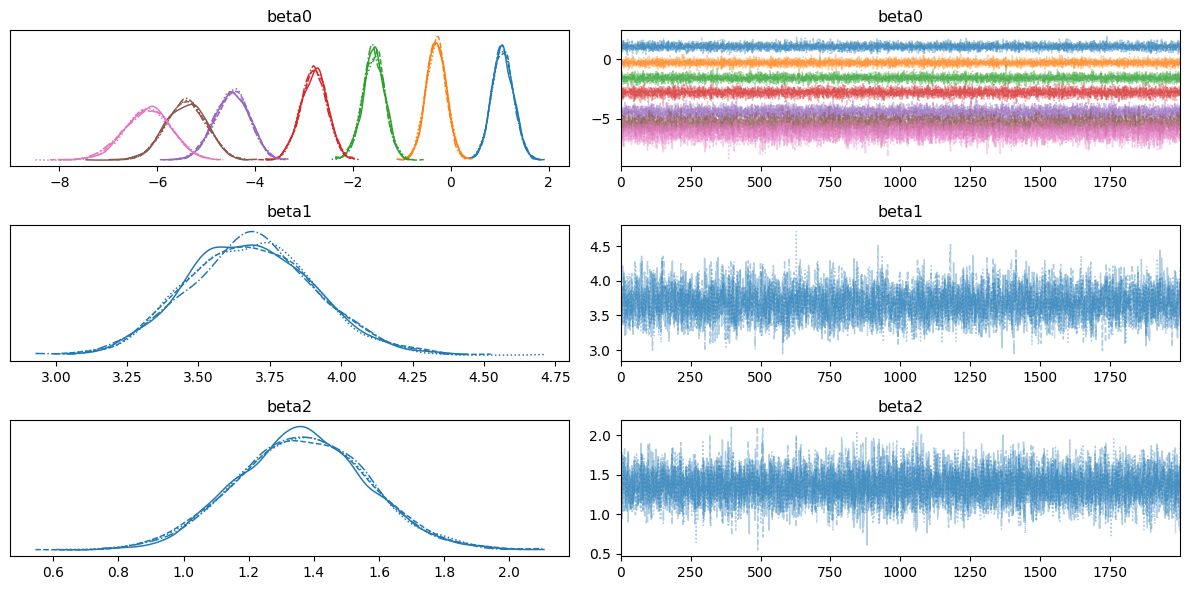

In [85]:
import matplotlib.pyplot as plt
import arviz as az

az.summary(trace, var_names=["beta0", "beta1", "beta2"], filter_vars="like", kind="diagnostics")
az.plot_trace(trace, var_names=["beta0", "beta1", "beta2"])
plt.tight_layout()
plt.show()

<h3>3.4 Plot posterior success probability against flow and observations</h3>

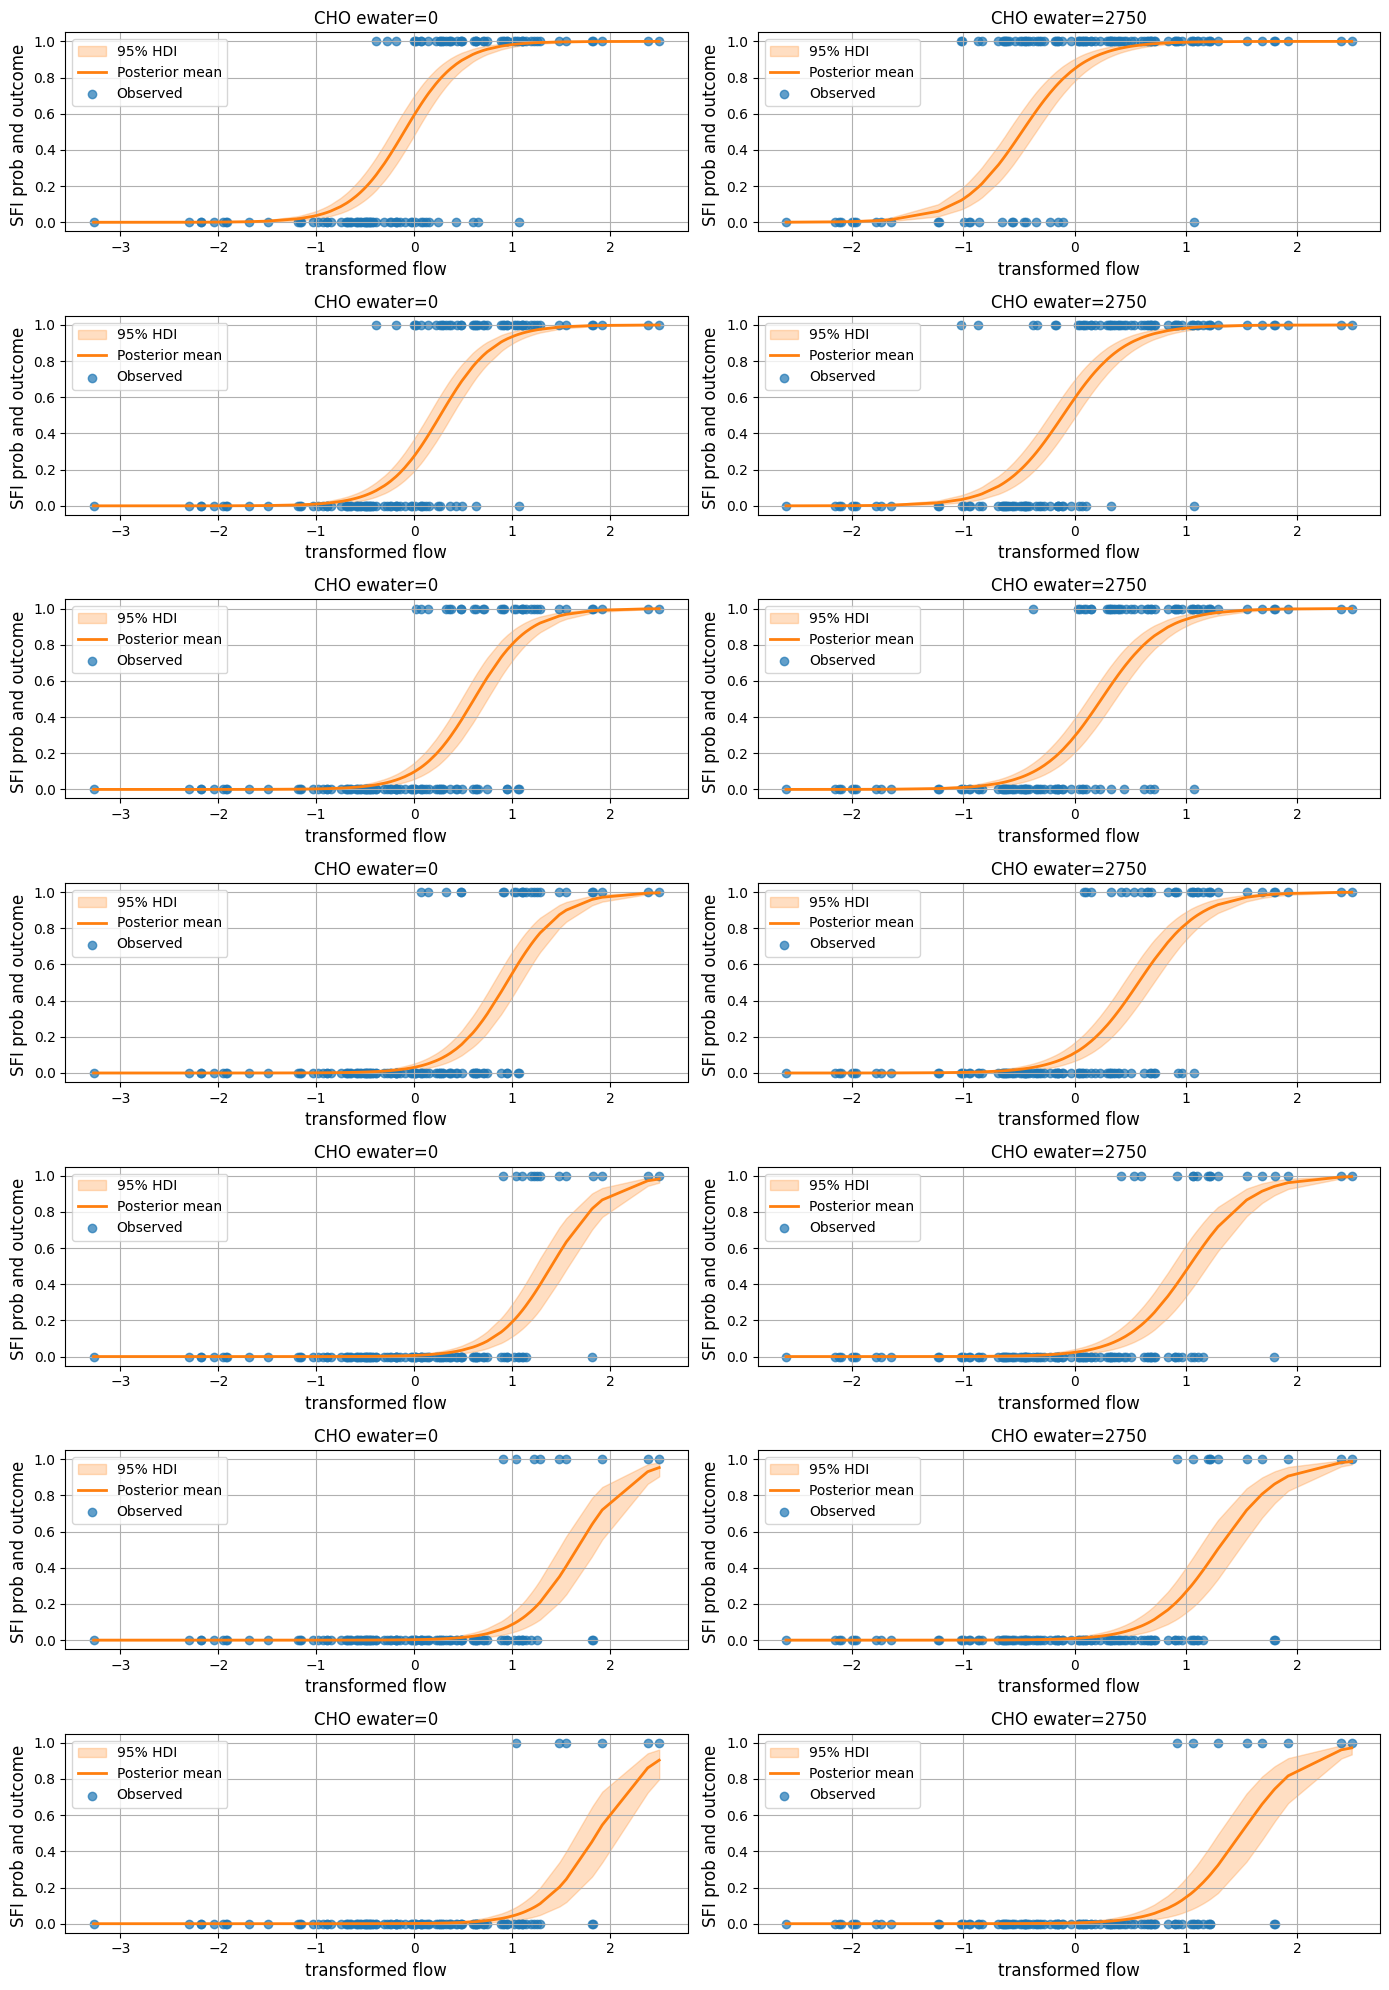

In [86]:
def plot_posterior_vs_predictor(location,indicator_idx,ewater_idx, trace, data, ax=None):

    def hdi(samples, hdi_prob=0.95):
        """
        Compute the High Density Interval (HDI) using percentiles.
        """
        lower_percentile = (1 - hdi_prob) / 2
        upper_percentile = 1 - lower_percentile
        lower_bound = np.percentile(samples, lower_percentile * 100, axis=0)
        upper_bound = np.percentile(samples, upper_percentile * 100, axis=0)
        return np.array([lower_bound, upper_bound]).T   

    ewater_predictor = ewater_values[ewater_idx] / np.max(ewater_values) - 0.5
    
    sel_data = data[data["indicator_idx"]==indicator_idx]
    sel_data = sel_data[sel_data["ewater"]==ewater_predictor]

    # Sort the data by the predictor values
    sorted_data = sel_data.sort_values(by="predictor1")   
    sorted_x1 = sorted_data["predictor1"].values

    # Extract posterior samples
    beta0_samples = trace.posterior["beta0"][:,:,indicator_idx].values.ravel()
    beta1_samples = trace.posterior["beta1"][:,:].values.ravel()
    beta2_samples = trace.posterior["beta2"][:,:].values.ravel()
    
    mu_samples = beta0_samples[:, None] + beta1_samples[:, None] * sorted_x1  + \
                 beta2_samples[:, None] * ewater_predictor

    # Calculate probabilities using the inverse logit
    p_samples = 1 / (1 + np.exp(-mu_samples))

    # Compute mean and 95% HDI of the posterior predictions
    mean_posterior = np.mean(p_samples, axis=0)
    hdi_posterior = hdi(p_samples, hdi_prob=0.95)

    # Plot the 95% HDI for the posterior probabilities
    ax.fill_between(sorted_x1, hdi_posterior[:, 0], hdi_posterior[:, 1], color="C1", alpha=0.25, label="95% HDI")

    # Plot the mean posterior probabilities
    ax.plot(sorted_x1, mean_posterior, color="C1", label="Posterior mean", linewidth=2)

    observed = sorted_data["predictand"].values
    ax.scatter(sorted_x1, observed, label="Observed", color="C0", alpha=0.7)

    # Set plot labels
    ax.set_xlabel(f"transformed flow", fontsize=12)
    ax.set_ylabel(f"SFI prob and outcome ", fontsize=12)
    
    title_text = f"{location} ewater={ewater_values[ewater_idx]}"
    ax.set_title(title_text, fontsize=12)

    # Add a legend
    ax.legend(loc="best")

    # Add gridlines for readability
    ax.grid(True)


# Create a figure with subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(14, 20))

# Flatten the axes array to iterate over it
axes = axes.flatten()

indicators = get_indicators(location)

for i, indicator in enumerate(indicators):    
    for j, ewater in enumerate(ewater_values):
                
        model_trace = traces_combined_shared_effects[location]
        model_data = data_combined_shared_effects[location]
        ax = axes[i * 2 + j]  # Select the appropriate axis for the plot
        plot_posterior_vs_predictor(location,i,j,trace=model_trace, data=model_data, ax=ax)
        
plt.tight_layout()
plt.show()

<h3>3.5 Cross-validation</h3>

In [87]:
import time

import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az
import xarray as xr

indicators = get_indicators(location)

nyears = data['year_idx'].nunique()
nsplits = 20
nchains = 4
ndraws = 4000
ntune = 2000
nsamples = nchains * ndraws

bin_width = nyears / nsplits
bin_edges = [int(i * bin_width) for i in range(nsplits + 1)]

predictive_samples_array = np.full((len(ewater_values), len(indicators), nyears, nsamples), np.nan)
obs_array = np.full((len(ewater_values), len(indicators), nyears), np.nan)

n_xv_iterations = len(ewater_values) * nsplits
xv_i = 1
time0 = time.time()

# sel_data = data[indicators + ["inflow", "ewater", "year_idx"]]
# Melt the dataframe
sel_data = pd.melt(
    data,
    id_vars=['inflow', 'ewater', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

for split_i in range(nsplits):

    test_years_idx = np.arange(bin_edges[split_i], bin_edges[split_i + 1], dtype=int)

    test_data = sel_data[sel_data["year_idx"].isin(test_years_idx)]
    train_data = sel_data[~sel_data["year_idx"].isin(test_years_idx)]

    # Standardize inflow on training set
    predictor1_training = np.log(train_data["inflow"])
    predictor1_training_mean = predictor1_training.mean()
    predictor1_training_std = predictor1_training.std()
    predictor1_training = (predictor1_training - predictor1_training_mean) / predictor1_training_std

    predictor1_test = np.log(test_data["inflow"])
    predictor1_test = (predictor1_test - predictor1_training_mean) / predictor1_training_std

    predictor2_training = train_data["ewater"]
    predictor2_training = (predictor2_training / data["ewater"].max()) - 0.5
    predictor2_test = test_data["ewater"]
    predictor2_test = (predictor2_test / data["ewater"].max()) - 0.5

    predictor3_training = train_data["indicator_idx"]
    predictor3_test = test_data["indicator_idx"]

    predictand_training = train_data["target"]
    predictand_test = test_data["target"]

    # ====== PyMC Model =======

    model = shared_effects_model(predictor1_training, predictor2_training, predictor3_training, predictand_training)

    trace = pymc.sample(draws=ndraws, tune=ntune, chains=nchains, target_accept=0.85,
                       model=model)

    for ewater_i, ewater in enumerate(ewater_values):
        ewater_scaled = ewater / data["ewater"].max() - 0.5
        ewater_idx = predictor2_test == ewater_scaled

        with model:
            pymc.set_data({
                "x1": predictor1_test[ewater_idx],
                "x2": predictor2_test[ewater_idx],
                "idx": predictor3_test[ewater_idx]
            })

            posterior_pred = pymc.sample_posterior_predictive(trace, var_names=["p"], progressbar=False, predictions=True)
            posterior_predictive_samples = posterior_pred.predictions["p"].values
            posterior_predictive_samples = posterior_predictive_samples.reshape(-1, posterior_predictive_samples.shape[2]).T

            # Fill arrays
            for ind_i in range(len(indicators)):
                ind_mask = predictor3_test[ewater_idx] == ind_i
                year_idx_subset = test_data["year_idx"][ewater_idx][ind_mask]
                predictive_samples_array[ewater_i, ind_i, year_idx_subset, :] = posterior_predictive_samples[ind_mask]
                obs_array[ewater_i, ind_i, year_idx_subset] = predictand_test[ewater_idx][ind_mask]

        print(f"{xv_i / n_xv_iterations * 100:.2f}% of cross-validation loops complete.   {time.time() - time0:.2f}s elapsed")
        xv_i += 1


# Create xarrays and save as before
predictions_dict = {
    "ewater": np.array([0, 1]),
    "indicator_idx": np.arange(len(indicators), dtype=int),
    "year_idx": data['year_idx'].unique(),
    "sample": np.arange(nsamples)
}

obs_dict = {
    "ewater": np.array([0, 1]),
    "indicator_idx": np.arange(len(indicators), dtype=int),
    "year_idx": data['year_idx'].unique()
}

predictions_xr = xr.DataArray(predictive_samples_array, coords=predictions_dict, dims=["ewater", "indicator_idx", "year_idx", "sample"])
obs_xr = xr.DataArray(obs_array, coords=obs_dict, dims=["ewater", "indicator_idx", "year_idx"])

predictions_xr.to_netcdf(f'../../../data/xv_data/{location}_posterior_predictive_combined_ind_intercept_model.nc')
obs_xr.to_netcdf(f'../../../data/xv_data/{location}_obs_combined_ind_intercept_model.nc')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Sampling: []
Sampling: []


2.50% of cross-validation loops complete.   24.90s elapsed
5.00% of cross-validation loops complete.   25.32s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Sampling: []
Sampling: []


7.50% of cross-validation loops complete.   51.56s elapsed
10.00% of cross-validation loops complete.   52.04s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


12.50% of cross-validation loops complete.   77.55s elapsed
15.00% of cross-validation loops complete.   77.94s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


17.50% of cross-validation loops complete.   103.36s elapsed
20.00% of cross-validation loops complete.   103.78s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


22.50% of cross-validation loops complete.   130.66s elapsed
25.00% of cross-validation loops complete.   131.06s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


27.50% of cross-validation loops complete.   156.53s elapsed
30.00% of cross-validation loops complete.   156.93s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


32.50% of cross-validation loops complete.   182.33s elapsed
35.00% of cross-validation loops complete.   182.73s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


37.50% of cross-validation loops complete.   209.36s elapsed
40.00% of cross-validation loops complete.   209.76s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


42.50% of cross-validation loops complete.   234.76s elapsed
45.00% of cross-validation loops complete.   235.15s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


47.50% of cross-validation loops complete.   260.60s elapsed
50.00% of cross-validation loops complete.   261.09s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


52.50% of cross-validation loops complete.   287.95s elapsed
55.00% of cross-validation loops complete.   288.45s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


57.50% of cross-validation loops complete.   313.54s elapsed
60.00% of cross-validation loops complete.   314.03s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Sampling: []
Sampling: []


62.50% of cross-validation loops complete.   338.59s elapsed
65.00% of cross-validation loops complete.   339.02s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


67.50% of cross-validation loops complete.   365.74s elapsed
70.00% of cross-validation loops complete.   366.13s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Sampling: []
Sampling: []


72.50% of cross-validation loops complete.   390.99s elapsed
75.00% of cross-validation loops complete.   391.43s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


77.50% of cross-validation loops complete.   418.06s elapsed
80.00% of cross-validation loops complete.   418.45s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


82.50% of cross-validation loops complete.   443.65s elapsed
85.00% of cross-validation loops complete.   444.11s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Sampling: []
Sampling: []


87.50% of cross-validation loops complete.   469.52s elapsed
90.00% of cross-validation loops complete.   469.91s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Sampling: []
Sampling: []


92.50% of cross-validation loops complete.   496.32s elapsed
95.00% of cross-validation loops complete.   496.72s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Sampling: []
Sampling: []


97.50% of cross-validation loops complete.   521.75s elapsed
100.00% of cross-validation loops complete.   522.21s elapsed


<h2>4. Combined model with shared slopes and lagged predictor</h2>

<h3>4.1 Define model</h3>

In [88]:
def shared_effects_lagged_model(predictor1, predictor2, predictor3, predictor4, predictand):
    
    with pymc.Model() as model:

        n = len(np.unique(predictor3))
        
        beta0 = pymc.Normal("beta0", mu=0, sigma=5, shape=n)
        beta1 = pymc.Normal("beta1", mu=0, sigma=5)
        beta2 = pymc.Normal("beta2", mu=0, sigma=5)
        beta3 = pymc.Normal("beta3", mu=0, sigma=5)
        
        x1 = pymc.Data("x1", predictor1)
        x2 = pymc.Data("x2", predictor2)
        x3 = pymc.Data("x3", predictor3)
        idx = pymc.Data("idx", predictor4)

        mu = beta0[idx] + beta1 * x1 + beta2 * x2 + beta3 * x3

        p = pymc.Deterministic("p", pmath.invlogit(mu))

        y = pymc.Bernoulli("y", p=p, observed=predictand)
    
    return model

<h3>4.2 Fit model</h3>

In [89]:
import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az

indicators = get_indicators(location)

sel_data = pd.melt(
    data,
    id_vars=['inflow', 'lagged_inflow', 'ewater', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

traces_combined_shared_effects_lagged = {}
data_combined_shared_effects_lagged = {}
    
predictor1 = np.log(sel_data["inflow"])
predictor1 = (predictor1 - predictor1.mean())/predictor1.std()

predictor2 = sel_data["ewater"]
predictor2 = (predictor2 / sel_data["ewater"].max()) - 0.5

predictor3 = np.log(sel_data["lagged_inflow"])
predictor3 = (predictor3 - predictor3.mean())/predictor3.std()

predictor4 = sel_data["indicator_idx"]

predictand = sel_data["target"]
        
model = shared_effects_lagged_model(predictor1, predictor2, predictor3, predictor4, predictand)
    
# Perform MCMC sampling
trace = pymc.sample(
    draws=2000,
    tune=4000,
    chains=4,
    target_accept=0.85,
    model=model
)
   
traces_combined_shared_effects_lagged[f"{location}"] = trace
    
ptor_ptand_data = pd.DataFrame(predictor1)
ptor_ptand_data = ptor_ptand_data.rename({"inflow":"predictor1"}, axis=1)
ptor_ptand_data["ewater"] = predictor2
ptor_ptand_data["predictor3"] = predictor3
ptor_ptand_data["indicator_idx"] = predictor4
ptor_ptand_data["predictand"] = predictand
        
data_combined_shared_effects_lagged[f"{location}"] = ptor_ptand_data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 51 seconds.


<h3>4.3 Plot traces</h3>

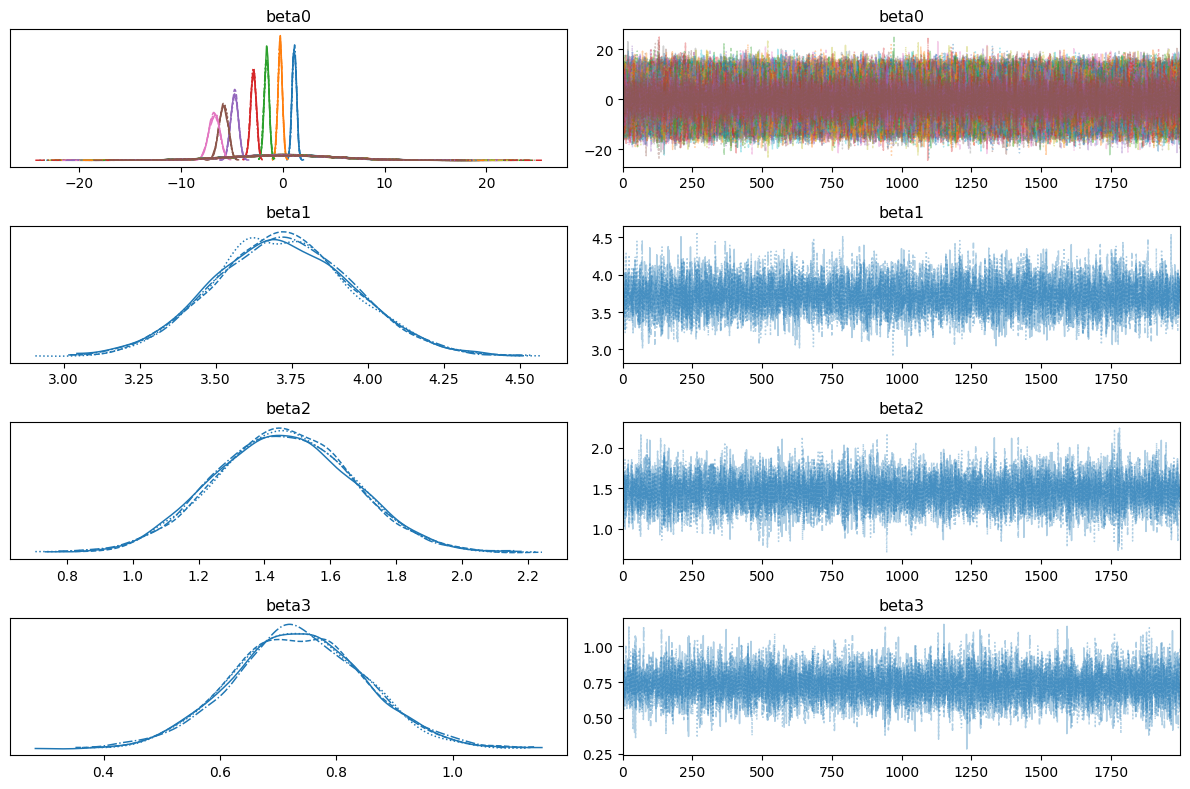

In [90]:
import matplotlib.pyplot as plt
import arviz as az

az.summary(trace, var_names=["beta0", "beta1", "beta2", "beta3"], filter_vars="like", kind="diagnostics")
az.plot_trace(trace, var_names=["beta0", "beta1", "beta2", "beta3"])
plt.tight_layout()
plt.show()

<h3>4.4 Plot posterior success probability against flow and observations</h3>

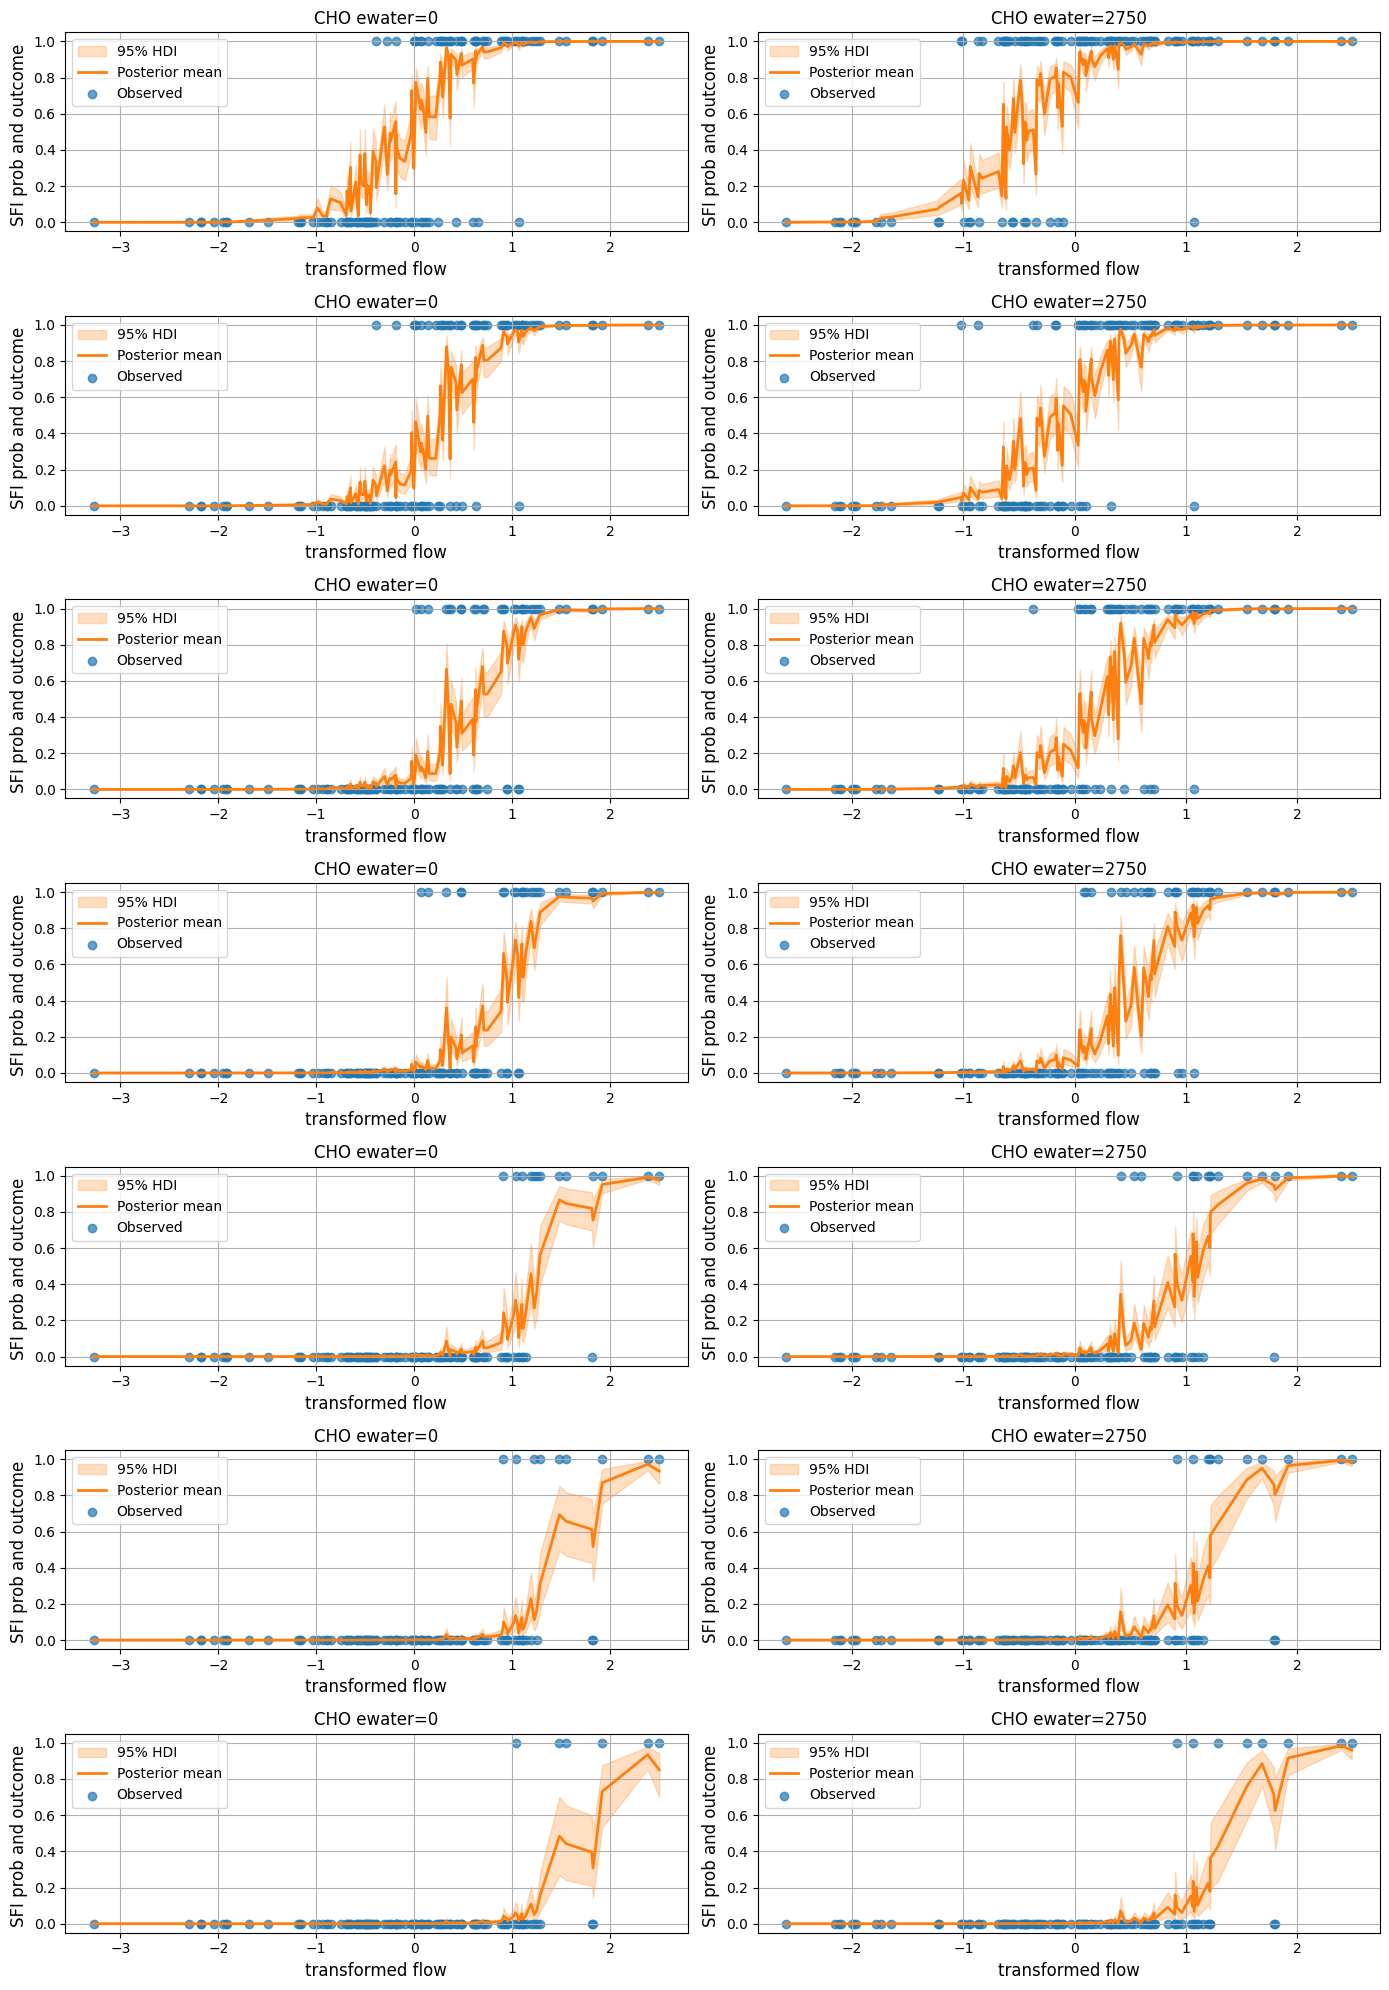

In [91]:
def plot_posterior_vs_predictor(location,indicator_idx,ewater_idx, trace, data, ax=None):

    def hdi(samples, hdi_prob=0.95):
        """
        Compute the High Density Interval (HDI) using percentiles.
        """
        lower_percentile = (1 - hdi_prob) / 2
        upper_percentile = 1 - lower_percentile
        lower_bound = np.percentile(samples, lower_percentile * 100, axis=0)
        upper_bound = np.percentile(samples, upper_percentile * 100, axis=0)
        return np.array([lower_bound, upper_bound]).T   

    ewater_predictor = ewater_values[ewater_idx] / np.max(ewater_values) - 0.5
    
    sel_data = data[data["indicator_idx"]==indicator_idx]
    sel_data = sel_data[sel_data["ewater"]==ewater_predictor]

    # Sort the data by the predictor values
    sorted_data = sel_data.sort_values(by="predictor1")   
    sorted_x1 = sorted_data["predictor1"].values
    sorted_x3 = sorted_data["predictor3"].values
    
    # Extract posterior samples
    beta0_samples = trace.posterior["beta0"][:,:,indicator_idx].values.ravel()
    beta1_samples = trace.posterior["beta1"][:,:].values.ravel()
    beta2_samples = trace.posterior["beta2"][:,:].values.ravel()
    beta3_samples = trace.posterior["beta3"][:,:].values.ravel()
    
    mu_samples = beta0_samples[:, None] + beta1_samples[:, None] * sorted_x1  + \
                 beta2_samples[:, None] * ewater_predictor + beta3_samples[:, None] * sorted_x3

    # Calculate probabilities using the inverse logit
    p_samples = 1 / (1 + np.exp(-mu_samples))

    # Compute mean and 95% HDI of the posterior predictions
    mean_posterior = np.mean(p_samples, axis=0)
    hdi_posterior = hdi(p_samples, hdi_prob=0.95)

    # Plot the 95% HDI for the posterior probabilities
    ax.fill_between(sorted_x1, hdi_posterior[:, 0], hdi_posterior[:, 1], color="C1", alpha=0.25, label="95% HDI")

    # Plot the mean posterior probabilities
    ax.plot(sorted_x1, mean_posterior, color="C1", label="Posterior mean", linewidth=2)

    observed = sorted_data["predictand"].values
    ax.scatter(sorted_x1, observed, label="Observed", color="C0", alpha=0.7)

    # Set plot labels
    ax.set_xlabel(f"transformed flow", fontsize=12)
    ax.set_ylabel(f"SFI prob and outcome ", fontsize=12)
    
    title_text = f"{location} ewater={ewater_values[ewater_idx]}"
    ax.set_title(title_text, fontsize=12)

    # Add a legend
    ax.legend(loc="best")

    # Add gridlines for readability
    ax.grid(True)


# Create a figure with subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(14, 20))

# Flatten the axes array to iterate over it
axes = axes.flatten()

indicators = get_indicators(location)

for i, indicator in enumerate(indicators):    
    for j, ewater in enumerate(ewater_values):
                
        model_trace = traces_combined_shared_effects_lagged[location]
        model_data = data_combined_shared_effects_lagged[location]
        ax = axes[i * 2 + j]  # Select the appropriate axis for the plot
        plot_posterior_vs_predictor(location,i,j,trace=model_trace, data=model_data, ax=ax)
        
plt.tight_layout()
plt.show()

<h3>4.5 Cross-validation</h3>

In [92]:
import time

import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az
import xarray as xr

indicators = get_indicators(location)

nyears = data['year_idx'].nunique()
nsplits = 20
nchains = 4
ndraws = 4000
ntune = 2000
nsamples = nchains * ndraws

bin_width = nyears / nsplits
bin_edges = [int(i * bin_width) for i in range(nsplits + 1)]

predictive_samples_array = np.full((len(ewater_values), len(indicators), nyears, nsamples), np.nan)
obs_array = np.full((len(ewater_values), len(indicators), nyears), np.nan)

n_xv_iterations = len(ewater_values) * nsplits
xv_i = 1
time0 = time.time()

# sel_data = data[indicators + ["inflow", "ewater", "year_idx"]]
# Melt the dataframe
sel_data = pd.melt(
    data,
    id_vars=['inflow', 'ewater', 'lagged_inflow', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

for split_i in range(nsplits):

    test_years_idx = np.arange(bin_edges[split_i], bin_edges[split_i + 1], dtype=int)
    
    test_data = sel_data[sel_data["year_idx"].isin(test_years_idx)]
    train_data = sel_data[~sel_data["year_idx"].isin(test_years_idx)]

    # Standardize inflow on training set
    predictor1_training = np.log(train_data["inflow"])
    predictor1_training_mean = predictor1_training.mean()
    predictor1_training_std = predictor1_training.std()
    predictor1_training = (predictor1_training - predictor1_training_mean) / predictor1_training_std

    predictor1_test = np.log(test_data["inflow"])
    predictor1_test = (predictor1_test - predictor1_training_mean) / predictor1_training_std

    predictor2_training = train_data["ewater"]
    predictor2_training = (predictor2_training / data["ewater"].max()) - 0.5
    predictor2_test = test_data["ewater"]
    predictor2_test = (predictor2_test / data["ewater"].max()) - 0.5

    predictor3_training = np.log(train_data["lagged_inflow"])
    predictor3_training_mean = predictor3_training.mean()
    predictor3_training_std = predictor3_training.std()
    predictor3_training = (predictor3_training - predictor3_training_mean) / predictor3_training_std

    predictor3_test = np.log(test_data["lagged_inflow"])
    predictor3_test = (predictor3_test - predictor3_training_mean) / predictor3_training_std

    predictor4_training = train_data["indicator_idx"]
    predictor4_test = test_data["indicator_idx"]

    predictand_training = train_data["target"]
    predictand_test = test_data["target"]


    # ====== PyMC Model =======

    model = shared_effects_lagged_model(predictor1_training, predictor2_training, predictor3_training, predictor4_training, predictand_training)

    trace = pymc.sample(draws=ndraws, tune=ntune, chains=nchains, target_accept=0.85,
                       model=model)

    for ewater_i, ewater in enumerate(ewater_values):
        ewater_scaled = ewater / data["ewater"].max() - 0.5
        ewater_idx = predictor2_test == ewater_scaled

        with model:
            pymc.set_data({
                "x1": predictor1_test[ewater_idx],
                "x2": predictor2_test[ewater_idx],
                "x3": predictor3_test[ewater_idx],
                "idx": predictor4_test[ewater_idx]
            })

            posterior_pred = pymc.sample_posterior_predictive(trace, var_names=["p"], progressbar=False, predictions=True)
            posterior_predictive_samples = posterior_pred.predictions["p"].values
            posterior_predictive_samples = posterior_predictive_samples.reshape(-1, posterior_predictive_samples.shape[2]).T

            # Fill arrays
            for ind_i in range(len(indicators)):
                ind_mask = predictor4_test[ewater_idx] == ind_i
                year_idx_subset = test_data["year_idx"][ewater_idx][ind_mask]
                predictive_samples_array[ewater_i, ind_i, year_idx_subset, :] = posterior_predictive_samples[ind_mask]
                obs_array[ewater_i, ind_i, year_idx_subset] = predictand_test[ewater_idx][ind_mask]

        print(f"{xv_i / n_xv_iterations * 100:.2f}% of cross-validation loops complete.   {time.time() - time0:.2f}s elapsed")
        xv_i += 1


# Create xarrays and save as before
predictions_dict = {
    "ewater": np.array([0, 1]),
    "indicator_idx": np.arange(len(indicators), dtype=int),
    "year_idx": data['year_idx'].unique(),
    "sample": np.arange(nsamples)
}

obs_dict = {
    "ewater": np.array([0, 1]),
    "indicator_idx": np.arange(len(indicators), dtype=int),
    "year_idx": data['year_idx'].unique()
}

predictions_xr = xr.DataArray(predictive_samples_array, coords=predictions_dict, dims=["ewater", "indicator_idx", "year_idx", "sample"])
obs_xr = xr.DataArray(obs_array, coords=obs_dict, dims=["ewater", "indicator_idx", "year_idx"])

predictions_xr.to_netcdf(f'../../../data/xv_data/{location}_posterior_predictive_combined_ind_intercept_lagged_model.nc')
obs_xr.to_netcdf(f'../../../data/xv_data/{location}_obs_combined_ind_intercept_lagged_model.nc')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


2.50% of cross-validation loops complete.   54.58s elapsed
5.00% of cross-validation loops complete.   55.07s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 49 seconds.
Sampling: []
Sampling: []


7.50% of cross-validation loops complete.   109.02s elapsed
10.00% of cross-validation loops complete.   109.64s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 49 seconds.
Sampling: []
Sampling: []


12.50% of cross-validation loops complete.   163.68s elapsed
15.00% of cross-validation loops complete.   164.16s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


17.50% of cross-validation loops complete.   220.55s elapsed
20.00% of cross-validation loops complete.   221.04s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


22.50% of cross-validation loops complete.   275.50s elapsed
25.00% of cross-validation loops complete.   276.02s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


27.50% of cross-validation loops complete.   331.23s elapsed
30.00% of cross-validation loops complete.   331.73s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 49 seconds.
Sampling: []
Sampling: []


32.50% of cross-validation loops complete.   385.93s elapsed
35.00% of cross-validation loops complete.   386.44s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


37.50% of cross-validation loops complete.   443.57s elapsed
40.00% of cross-validation loops complete.   444.10s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 51 seconds.
Sampling: []
Sampling: []


42.50% of cross-validation loops complete.   500.37s elapsed
45.00% of cross-validation loops complete.   500.86s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


47.50% of cross-validation loops complete.   555.93s elapsed
50.00% of cross-validation loops complete.   556.42s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 52 seconds.
Sampling: []
Sampling: []


52.50% of cross-validation loops complete.   613.33s elapsed
55.00% of cross-validation loops complete.   613.90s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


57.50% of cross-validation loops complete.   670.68s elapsed
60.00% of cross-validation loops complete.   671.20s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 51 seconds.
Sampling: []
Sampling: []


62.50% of cross-validation loops complete.   726.80s elapsed
65.00% of cross-validation loops complete.   727.31s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


67.50% of cross-validation loops complete.   782.58s elapsed
70.00% of cross-validation loops complete.   783.13s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


72.50% of cross-validation loops complete.   837.48s elapsed
75.00% of cross-validation loops complete.   837.94s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


77.50% of cross-validation loops complete.   893.80s elapsed
80.00% of cross-validation loops complete.   894.33s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 51 seconds.
Sampling: []
Sampling: []


82.50% of cross-validation loops complete.   949.94s elapsed
85.00% of cross-validation loops complete.   950.48s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


87.50% of cross-validation loops complete.   1004.95s elapsed
90.00% of cross-validation loops complete.   1005.44s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 50 seconds.
Sampling: []
Sampling: []


92.50% of cross-validation loops complete.   1060.23s elapsed
95.00% of cross-validation loops complete.   1060.82s elapsed


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 49 seconds.
Sampling: []
Sampling: []


97.50% of cross-validation loops complete.   1116.61s elapsed
100.00% of cross-validation loops complete.   1117.16s elapsed
